In [1]:
# General modules
import sys
import os
import session_info
import warnings
from pyprojroot.here import here
import glob
import pandas as pd
import numpy as np
from sklearn.mixture import GaussianMixture

import matplotlib.pyplot as plt
from IPython.display import display

from tqdm import tqdm
# Specific modules
import scanpy as sc
import anndata as ad
import scienceplots

# Setting some parameters
warnings.filterwarnings("ignore")
sys.path.insert(1, str(here('bin')))

plt.style.use(['science','nature','no-latex'])
dpi_fig_save = 300
sc.set_figure_params(dpi=100, dpi_save=dpi_fig_save, vector_friendly=True)


# Specific modules
import mygene
import requests
import re

sys.path.insert(1, str(here('bin')))

# Setting some parameters
warnings.filterwarnings("ignore")

# Import functions
from customPythonFunctions import balanced_sample
from customPalette import diseaseCategories

pd.options.display.max_columns=300
pd.options.display.max_rows=1000

overwriteFigure = True

In [2]:
print("Main directory path: {}".format(here()))

# create result directories
os.makedirs(here('00_data_processing/results/extended_obs'), exist_ok = True)
os.makedirs(here('00_data_processing/results/study_metadata'), exist_ok = True)

os.makedirs(here('00_data_processing/figures'), exist_ok=True)

Main directory path: /scratch_isilon/groups/singlecell/shared/projects/Inflammation-PBMCs-Atlas-R1


# Preparing complementary data

HUGO gene-name set

Different study may used different version of annotation files. To harmonize gene names we compare all of them with the HUGO complete gene set (version of July, 2023). We searched each gene names among HUGO official symbol, if not found we consider aliases, and finally previus associated symbols.

If the gene names was not found in any of these sets we mark the gene as 'non-official', to be removed in the downstream analyses.




In [3]:
# Download the last gene set catalog
extHUGO_DF_fn = here('external_reference_data/hgnc_complete_set_2024-02-01_pandas.csv')
HUGOset_fn = here('external_reference_data/hgnc_complete_set_2024-02-01.txt')

if not os.path.isfile(extHUGO_DF_fn):

    print("Downloading HUGO gene name set")

    if not os.path.isfile(HUGOset_fn):
        url = 'https://ftp.ebi.ac.uk/pub/databases/genenames/hgnc/archive/monthly/tsv/hgnc_complete_set_2024-02-01.txt'
        c = requests.get(url, allow_redirects=True)
    
        open(HUGOset_fn, 'wb').write(c.content)

    HUGO_DF = pd.read_csv(HUGOset_fn, delimiter='\t', dtype=(str))
    HUGO_DF.fillna('', inplace=True)

    # extending the dataframe to include also alias and prev gene symbols
    pB = tqdm(total=HUGO_DF.shape[0])
    extHUGO_DF = pd.DataFrame(columns=['hgnc_id','symbol','alias_or_prev','ensembl_gene_id','locus_group'])
    for index, row in HUGO_DF.iterrows():
        alias_symbol_list = []
        prev_symbol_list = []
    
        if row['alias_symbol'] != '':
            alias_symbol_list = row['alias_symbol'].split('|')
    
        if row['prev_symbol'] != '':
            prev_symbol_list = row['prev_symbol'].split('|')
    
        alias_prev = list(set(alias_symbol_list + prev_symbol_list))
    
        if len(alias_prev) > 0:
            df_i = pd.DataFrame({'hgnc_id':row['hgnc_id'], 'symbol': row['symbol'], 'alias_or_prev': alias_prev, 
                                 'ensembl_gene_id':row['ensembl_gene_id'], 'locus_group':row['locus_group']})
        else:
            df_i = pd.DataFrame({'hgnc_id':row['hgnc_id'], 'symbol': row['symbol'], 'alias_or_prev': [''], 
                                 'ensembl_gene_id':row['ensembl_gene_id'], 'locus_group':row['locus_group']})
    
        extHUGO_DF = pd.concat([extHUGO_DF, df_i], axis=0)
        pB.update(1)
    extHUGO_DF.to_csv(extHUGO_DF_fn, sep= '\t', index=False)
else:

    print(" HUGO gene name set loaded from disk")
    
    extHUGO_DF = pd.read_csv(extHUGO_DF_fn, sep= '\t')

 HUGO gene name set loaded from disk


In [4]:
extHUGO_DF.loc[extHUGO_DF.hgnc_id == 'HGNC:31430',:]

,hgnc_id,symbol,alias_or_prev,ensembl_gene_id,locus_group
29802,HGNC:31430,LINC00595,C10orf101,ENSG00000230417,non-coding RNA


In [5]:
extHUGO_DF.loc[extHUGO_DF.hgnc_id == 'HGNC:45111',:]

,hgnc_id,symbol,alias_or_prev,ensembl_gene_id,locus_group
29927,HGNC:45111,LINC00856,NaN,ENSG00000230417,non-coding RNA


As you can see, there are two different HGNC symbol associated to the same ensemble_id.

We decided to keep the first one (*HGNC:31430*) because there is a correspondence between ensemble, symbol and hgnc id [[ref1](https://www.genecards.org/cgi-bin/carddisp.pl?gene=LINC00595),[ref2](https://www.genenames.org/data/gene-symbol-report/#!/hgnc_id/31430)]. 

While, *HGNC:45111* is associated to LINC00856 [[ref3](https://www.genenames.org/data/gene-symbol-report/#!/hgnc_id/45111)]

In [6]:
extHUGO_DF.loc[extHUGO_DF.hgnc_id == 'HGNC:45111',:] = None

In [7]:
def add_project_ids(adata = None, studyID = None, library_id_col = None, patient_id_col = None, timepointColID = None, pIDpattern = '[^a-zA-Z0-9]+', repWith = '', regex = True):
    # generating barcode for each library (gem_id)
    gemID_BC = pd.DataFrame({library_id_col: np.unique(adata.obs[library_id_col])})
    gemID_BC['INFL_lID'] = [f"{studyID}_L{l:03d}" for l in range(gemID_BC.shape[0])]         
    adata.obs = adata.obs.reset_index().merge(gemID_BC, on=library_id_col, how = 'left').set_index('index')

    # generating barcode for each patient
    adata.obs['INFL_pID'] = adata.obs[patient_id_col].str.replace(pIDpattern,repWith,regex=regex) # here we removed 00 to make shorten the ID
    assert(adata.obs['INFL_pID'].unique().shape[0] == adata.obs[patient_id_col].unique().shape[0])
    if timepointColID is not None:
        # if there are multiple timepoints or replicates from the same patient, we add a proper suffix (i.e., T#) after the corresponding pID

        # we are adding the information about the timepoint, armonizing the values ...
        pID_TP_df = adata.obs[['INFL_pID',timepointColID]].drop_duplicates()
        pID_TP_df['timepoint_replicate'] = pID_TP_df.sort_values(['INFL_pID',timepointColID]).groupby(['INFL_pID']).cumcount()
        # ... transfering back to the cell metadata timepoint_replicate annotation
        adObj_i.obs = adObj_i.obs.merge(pID_TP_df, on = ['INFL_pID',timepointColID])
        
    else:
        # otherwise, we will add T0 for consistency
        adObj_i.obs['timepoint_replicate'] = 0
    
    # # generating barcode for each cell
    adata.obs['INFL_lID_pID_TP'] = adata.obs[['INFL_lID', 'INFL_pID']].apply(lambda row: '_'.join(row.values.astype(str)), axis=1) + '_T' + adObj_i.obs['timepoint_replicate'].astype(str)
    
    adata.obs['cellID'] = adata.obs[['INFL_lID_pID_TP', 'cell_barcode']].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)
    adata.obs = adata.obs.reset_index(inplace=False).set_index('cellID', inplace=False)
    
    # generating patientID and sampleID 
    adata.obs['INFL_pID'] = studyID+'_'+adata.obs['INFL_pID'].astype(str)
    adata.obs['INFL_sID'] = adata.obs['INFL_pID'].astype(str)+'_T'+adObj_i.obs['timepoint_replicate'].astype(str)

    return None

In [8]:
datasetDF = pd.read_csv(here('00_data_processing/datasets/INFLAMMATION_ATLAS_datasets_curated.csv'))

pd.set_option('display.max_rows', None)
display(datasetDF)
pd.reset_option('display.max_rows')

,studyID,diseaseGroup,disease,dataSource,h5ad_FileName,ENSEMBLGeneID,externalValidation,chemistry,technology,cellrangerVersion,genomeVersion,expectedDoubletRate
0,SCGT00,homeostasis;IMID,HC;RA;PsA;IBDs_CD;IBDs_UC;PS;SLE,inhouse,INFLAMMATION_DOCTIS_week0_bothChemistry_merged...,YES,NO,mixed,mixed_GenoHashed,v6.1.1_NoIntrons,GRCh38_v32/Ensembl98,0.02
1,SCGT00val,IMID,RA,inhouse,INFLAMMATION_DOCTISvalidation_week0_merged.h5ad,YES,YES,3_GEX_V3,3_GEX_V3_GenoHashed,v6.1.1_NoIntrons,GRCh38_v32/Ensembl98,0.02
2,SCGT01,homeostasis,HC,inhouse,INFLAMMATION_EXERCISEHC_merged.h5ad,YES,NO,3_GEX_V3,3_GEX_V3_CellPlex,v6.1.1_NoIntrons,GRCh38_v32/Ensembl98,0.02
3,SCGT02,homeostasis;chronic_inflammation,HC;Asthma;COPD,inhouse,INFLAMMATION_ASTHMA-COPD-HC_merged.h5ad,YES,NO,3_GEX_V3,3HT_GEX_V3_GenoHashed,v6.1.1_NoIntrons,GRCh38_v32/Ensembl98,0.01
4,SCGT03,solid_tumors,BRCA,inhouse,INFLAMMATION_BRCA_time0_merged.h5ad,YES,NO,5_GEX_V2,5_GEX_V2,v6.1.1_NoIntrons,GRCh38_v32/Ensembl98,0.08
5,SCGT04,chronic_inflammation,cirrhosis,inhouse,INFLAMMATION_CIRRHOSIS_merged.h5ad,YES,NO,3_GEX_V3,3HT_GEX_V3_CellPlex,v6.1.1_NoIntrons,GRCh38_v32/Ensembl98,0.01
6,SCGT05,solid_tumors,CRC,inhouse,INFLAMMATION_CRC_merged.h5ad,YES,NO,5_GEX_V2,5_GEX_V2,v6.1.2_NoIntrons,GRCh38_v32/Ensembl98,0.08
7,SCGT06,homeostasis;infection,HC;COVID,inhouse,INFLAMMATION_COVID-HC_merged.h5ad,YES,YES,3_GEX_V3,3HT_GEX_V3_GenoHashed,v6.1.1_NoIntrons,GRCh38_v32/Ensembl98,0.01
8,Reyes2020,homeostasis;acute_inflammation,HC;sepsis,public,Reyes_NatMed_2020__Sepsis-HC.h5ad,NO,NO,3_GEX_V2,3_GEX_V2_Hashed,v2.1_NoIntrons,GRCh38/Ensembl87,0
9,Cillo2020,homeostasis;solid_tumors,HC;HNSCC,public,Cillo_Immunity_2020__HNSCC-HC.h5ad,YES,NO,3_GEX_V2,3_GEX_V2,v2.1,GRCh38,0.08


## Reading each single-cell dataset

**INFL_pID** = cleanPatientID, where cleanPatientID = originalPatientID without any non-alphanumeric characters.
(this column has to be renamed to *patientID*)

**INFL_lID** = LXXX, where XXX is an incremental number from 000 to 999, one for each library in a given study. (this column has to be renamed to *libraryID*)

**INFL_cID** = LXXX_cleanPatientID_NNNNNNNNNNNNNNNN, where NNNNNNNNNNNNNNNN is the original cell barcode. (this column has to be renamed to *cellID*)

In the mergedObs, we add *studyID_* as prefix for each identifier

We are try to harmonize columns name for the followin information, if available:
1. institute (where the data are collected),
2. age,
3. sex,
4. ethnicity,
5. smokingStatus (current/occasionally/never/former/unknown TO BE CHECKED),
6. BMI,
7. disease and diseaseStatus,
8. treatmentStatus (naive/treated/under/na) and therapyResponse,
9. timepoint_replicate (if there are multiple samples from the same individual, we will assign different number here)


In [ ]:
geneNameInfoDF = pd.DataFrame()
adObjList = []
ptMetadataList = []

for i, row in datasetDF.iterrows():
#for i, row in datasetDF.iloc[[dn]].iterrows():
    # ------------------------------------------------------ COMMON ------------------------------------------------------------ #
    studyID = row['studyID']

    if row['dataSource'] == 'public':
        file_path = os.path.join(here('00_data_processing/datasets/public_data/'), row['h5ad_FileName'])
    elif row['dataSource'] == 'inhouse':
        file_path = os.path.join(here('00_data_processing/datasets/inhouse_data/'), row['h5ad_FileName'])

    print(f"Reading {studyID}: {os.path.basename(file_path)}")    

    if os.path.exists(file_path):
        adObj_i = ad.read_h5ad(file_path)
    else:
        print(f"WARNING: skipped {os.path.basename(file_path)} because it doesn't exist. Please check!")
        print("")
        continue
        
    adObj_i.obs['studyID'] = studyID

    # chemistry
    if not row['chemistry'].startswith('mixed'):
        adObj_i.obs['INFL_chemistry'] = row['chemistry']
    if not row['technology'].startswith('mixed'):
        adObj_i.obs['INFL_technology'] = row['technology']

    # cell barcode
    adObj_i.obs['cell_barcode'] = [re.findall(r'[ATCG]{16}', c)[0] for c in adObj_i.obs.index]

    print("Original object")
    print(adObj_i)

    # delete any of 'obsm', 'obsp', and 'uns' fields if present
    del adObj_i.obsm
    del adObj_i.obsp
    del adObj_i.uns
    
    # --------------------------------------------- DATASET SPECIFIC ------------------------------------------------------------ #

    if row['h5ad_FileName'] in ['INFLAMMATION_DOCTIS_week0_bothChemistry_merged.h5ad']:

        # for consistency with other datasets
        adObj_i.obs.rename({'chemistry':'INFL_chemistry'}, axis = 1, inplace=True)
        adObj_i.obs['INFL_technology'] = adObj_i.obs['INFL_chemistry'].astype(str) + '_GenoHashed'

        colLibraryID = 'gem_id'
        colNamePatientID = 'demux_donor'
        pIDpattern = '[^a-zA-Z0-9]+|00' # here we removed also 00 to make shorten the ID
        add_project_ids(adata = adObj_i, studyID = studyID, library_id_col = colLibraryID, patient_id_col = colNamePatientID, pIDpattern = pIDpattern, repWith = '', regex = True) 

        # Only for this dataset we have to add chemistry info because many samples were sequenced with 3' AND 5' chemistry protocol (same library splitted in two)

        # changing the sampleID
        sID_chem = adObj_i.obs.INFL_sID.str.split('_T', expand=True)
        adObj_i.obs['INFL_sID'] = sID_chem[0] + '.' + [ '3P' if c.startswith('3_') else '5P' for c in adObj_i.obs.INFL_chemistry.astype(str)] + '_T' + sID_chem[1]
        
        # changing the cellID
        sID_chem = adObj_i.obs.reset_index()['cellID'].str.split('_', expand=True)
        adObj_i.obs.reset_index(inplace=True)
        adObj_i.obs['cellID'] = sID_chem[0] + '_' + sID_chem[1] + '_' + sID_chem[2] + '.' + [ '3P' if c.startswith('3_') else '5P' for c in adObj_i.obs.INFL_chemistry.astype(str)] + '_' + sID_chem[3] + '_' + sID_chem[4]
        adObj_i.obs.set_index('cellID', inplace=True)

        pMD_DF_i = adObj_i.obs[['INFL_pID', 'INFL_sID','timepoint_replicate', colNamePatientID, 'Disease', 'therapy', 
                                'Response', 'PersonalInformation.Sex', 'Birth.Donor.PresentAgeDonor','DerivedBMI',
                                'TobaccoFrequency.CigarettesFrequency','TobaccoFrequency.CigarsFrequency','TobaccoFrequency.SmokingPipeFrequency'
                               ]].drop_duplicates()
        
        # merging smoking information included in 'TobaccoFrequency.CigarettesFrequency', 'TobaccoFrequency.CigarsFrequency', and 'TobaccoFrequency.SmokingPipeFrequency'
        # with the following logic: Daily > Occasionally > Never
        # then, for combine this clinical features with other studies we performe the following change 'Daily' = 'yes', 'Never' = 'no'
        smokingDF = pMD_DF_i[['TobaccoFrequency.CigarettesFrequency','TobaccoFrequency.CigarsFrequency',
                              'TobaccoFrequency.SmokingPipeFrequency']].replace({'Never':0, 'Occasionally':1,'Daily':2, 'nan':np.nan}, inplace=False)
        
        smokingDF['smokingStatus'] = smokingDF.max(axis = 1)        
        smokingDF.replace({0:'non-smoker',1:'occasionally',2:'smoker'}, inplace=True)  
        pMD_DF_i['smokingStatus'] = smokingDF['smokingStatus']

        pMD_DF_i['smokingStatus'] = pd.Categorical(pMD_DF_i['smokingStatus'], categories=['non-smoker', 'occasionally', 'smoker'], ordered=False)

        
        # selecting columns with patient metadata
        pMD_DF_i.drop(['TobaccoFrequency.CigarettesFrequency','TobaccoFrequency.CigarsFrequency','TobaccoFrequency.SmokingPipeFrequency'], axis = 1, inplace = True)
        
        pMD_DF_i.rename(columns={'INFL_pID':'patientID', 'INFL_sID':'sampleID', colNamePatientID: 'old_sample_id', 'Disease':'disease', 'therapy':'treatmentStatus', 
                                'Response':'therapyResponse','PersonalInformation.Sex':'sex', 'Birth.Donor.PresentAgeDonor':'age','DerivedBMI':'BMI'}, inplace=True)

    elif row['h5ad_FileName'] in ['INFLAMMATION_DOCTISvalidation_week0_merged.h5ad']:

        colLibraryID = 'gem_id'
        colNamePatientID = 'demux_donor'
        pIDpattern = '[^a-zA-Z0-9]+|00' # here we removed also 00 to make shorten the ID
        add_project_ids(adata = adObj_i, studyID = studyID, library_id_col = colLibraryID, patient_id_col = colNamePatientID, pIDpattern = pIDpattern, repWith = '', regex = True) 
        
        pMD_DF_i = adObj_i.obs[['INFL_pID', 'INFL_sID','timepoint_replicate', colNamePatientID, 'Disease', 'therapy', 
                                'Response', 'Sex', 'Age','DerivedBMI','TobaccoFrequency.CigarettesFrequency','TobaccoFrequency.CigarsFrequency','TobaccoFrequency.SmokingPipeFrequency'
                               ]].drop_duplicates()
        
        # merging smoking information included in 'TobaccoFrequency.CigarettesFrequency', 'TobaccoFrequency.CigarsFrequency', and 'TobaccoFrequency.SmokingPipeFrequency'
        # with the following logic: Daily > Occasionally > Never
        # then, for combine this clinical features with other studies we performe the following change 'Daily' = 'yes', 'Never' = 'no'
        smokingDF = pMD_DF_i[['TobaccoFrequency.CigarettesFrequency','TobaccoFrequency.CigarsFrequency',
                              'TobaccoFrequency.SmokingPipeFrequency']].replace({'Never':0, 'Occasionally':1,'Daily':2, 'nan':np.nan}, inplace=False)
        
        smokingDF['smokingStatus'] = smokingDF.max(axis = 1)        
        smokingDF.replace({0:'non-smoker',1:'occasionally',2:'smoker'}, inplace=True)  
        pMD_DF_i['smokingStatus'] = smokingDF['smokingStatus']
        
        pMD_DF_i['smokingStatus'] = pd.Categorical(pMD_DF_i['smokingStatus'], categories=['non-smoker', 'occasionally', 'smoker'], ordered=False)
        
        
        # selecting columns with patient metadata
        pMD_DF_i.drop(['TobaccoFrequency.CigarettesFrequency','TobaccoFrequency.CigarsFrequency','TobaccoFrequency.SmokingPipeFrequency'], axis = 1, inplace = True)
        
        pMD_DF_i.rename(columns={'INFL_pID':'patientID', 'INFL_sID':'sampleID', colNamePatientID: 'old_sample_id', 'Disease':'disease', 'therapy':'treatmentStatus', 
                                'Response':'therapyResponse','Sex':'sex', 'Age':'age','DerivedBMI':'BMI'}, inplace=True)

    elif row['h5ad_FileName'] in ['INFLAMMATION_EXERCISEHC_merged.h5ad']:

        colLibraryID = 'gem_id'
        colNamePatientID = 'demux_donor'
        pIDpattern = '[^a-zA-Z1-9]+' # here we removed also all 0 character to shorten the ID
        add_project_ids(adata = adObj_i, studyID = studyID, library_id_col = colLibraryID, patient_id_col = colNamePatientID, pIDpattern = pIDpattern, repWith = '', regex = True) 
        
        # selecting columns with patient metadata
        pMD_DF_i = adObj_i.obs[['INFL_pID', 'INFL_sID', 'timepoint_replicate', colNamePatientID, 'age', 'sex', 'exercise_status']].drop_duplicates()
        pMD_DF_i.rename(columns={'INFL_pID':'patientID', 'INFL_sID':'sampleID', colNamePatientID: 'old_sample_id', 'age': 'binned_age', 'exercise_status':'diseaseStatus'}, inplace=True)
        pMD_DF_i['disease'] = 'Healthy'

    elif row['h5ad_FileName'] in ['INFLAMMATION_BRCA_time0_merged.h5ad']:
        
        colLibraryID = 'gem_id'
        colNamePatientID = 'donor_id'
        pIDpattern = '[^a-zA-Z0-9]+' 
        add_project_ids(adata = adObj_i, studyID = studyID, library_id_col = colLibraryID, patient_id_col = colNamePatientID, pIDpattern = pIDpattern, repWith = '', regex = True) 
        
        # selecting columns with patient metadata
        pMD_DF_i = adObj_i.obs[['INFL_pID', 'INFL_sID', 'timepoint_replicate', colNamePatientID, 'sex', 'age']].drop_duplicates()
        pMD_DF_i.rename(columns={'INFL_pID':'patientID', 'INFL_sID':'sampleID', colNamePatientID: 'old_sample_id'}, inplace=True)
        pMD_DF_i['disease'] = 'BRCA'

    elif row['h5ad_FileName'] in ['INFLAMMATION_ASTHMA-COPD-HC_merged.h5ad']:

        colLibraryID = 'gem_id'
        colNamePatientID = 'demux_donor'
        pIDpattern = '[^a-zA-Z0-9]+' 
        add_project_ids(adata = adObj_i, studyID = studyID, library_id_col = colLibraryID, patient_id_col = colNamePatientID, pIDpattern = pIDpattern, repWith = '', regex = True) 

        # We are generating a new column called 'diseaseStatus' to represent the status of the disease. 
        # For doing this: we aggregate the values in following columns ['GINA.step', 'GOLD'] adding the prefix to each value
        # np.nan -> na
        GINA = np.array(['GINA_{}'.format(g) if g != 'NA' else 'NA' for g in adObj_i.obs['GINA.step']])
        GOLD = np.array(['GOLD_{}'.format(g) if g != 'NA' else 'NA' for g in adObj_i.obs['GOLD']])
        GINA[GINA=='NA'] = GOLD[GINA=='NA']
        
        adObj_i.obs['diseaseStatus'] = GINA

        # we used the height and weight info to compute the BMI as weight[kg] / (height[m] ^ 2)

        adObj_i.obs['BMI'] = adObj_i.obs['weight'] / ((adObj_i.obs['height'] / 100)**2)

        # selecting columns with patient metadata
        pMD_DF_i = adObj_i.obs[['INFL_pID',  'INFL_sID', colNamePatientID, 'Gender', 'age', 'disease', 'therapy', 'smoking', 'height', 'weight','BMI','diseaseStatus',
                                'rhinitis', 'hayfever', 'eczema', 'leukocytes_blood','neutrophils_blood', 'lymphocytes_blood', 'monocytes_blood','eosinophils_blood']].drop_duplicates()
        pMD_DF_i.rename(columns={'INFL_pID':'patientID', 'INFL_sID':'sampleID', colNamePatientID: 'old_sample_id', 'Gender': 'sex', 'therapy':'treatmentStatus', 'smoking':'smokingStatus'}, inplace=True)
        pMD_DF_i = pMD_DF_i.replace('NA', np.nan)


    elif row['h5ad_FileName'] in ['INFLAMMATION_CIRRHOSIS_merged.h5ad']:
        
        colLibraryID = 'gem_id'
        colNamePatientID = 'donor_id'
        pIDpattern = '[^a-zA-Z0-9]+' 
        add_project_ids(adata = adObj_i, studyID = studyID, library_id_col = colLibraryID, patient_id_col = colNamePatientID, pIDpattern = pIDpattern, repWith = '', regex = True) 

        # selecting columns with patient metadata
        pMD_DF_i = adObj_i.obs[['INFL_pID', 'INFL_sID', 'timepoint_replicate', colNamePatientID, 'disease', 'sex', 'age', 'disease_subtype']].drop_duplicates()
        pMD_DF_i.rename(columns={'INFL_pID':'patientID', 'INFL_sID':'sampleID', colNamePatientID: 'old_sample_id', 'disease_subtype':'diseaseStatus'}, inplace=True)

        # The dataset was generated by spanish people. So, sex definitions are M = Mujer and H = Hombre.
        # To avoid any problems while merging the metadata we are replacing value here.
        pMD_DF_i['sex'].replace({'M':'female','H':'male'}, inplace = True) 
    
    elif row['h5ad_FileName'] in ['INFLAMMATION_CRC_merged.h5ad']:

        colLibraryID = 'patient_id' #each patient where sequenced in a specific library. So the same column is used for both
        colNamePatientID = 'patient_id'
        pIDpattern = '[^a-zA-Z0-9]+' 
        add_project_ids(adata = adObj_i, studyID = studyID, library_id_col = colLibraryID, patient_id_col = colNamePatientID, pIDpattern = pIDpattern, repWith = '', regex = True) 
        
        # selecting columns with patient metadata
        # IMPORTANT: This dataset, has 2 patients sampled at 4 timepoints - then, patient metadata only has general information
        pMD_DF_i = adObj_i.obs[['INFL_pID', 'INFL_sID', 'timepoint_replicate', colNamePatientID, 'Age', 'Sex', 'MSI.status', 'disease', 'Additional.info']].drop_duplicates()
        pMD_DF_i.rename(columns={'INFL_pID':'patientID', 'INFL_sID':'sampleID', colNamePatientID: 'old_sample_id', 'Age': 'age', 'Sex': 'sex', 'MSI.status':'diseaseStatus'}, inplace=True)

    elif row['h5ad_FileName'] in ['INFLAMMATION_COVID-HC_merged.h5ad']:

        colLibraryID = 'gem_id' #each patient where sequenced in a specific library. So the same column is used for both
        colNamePatientID = 'demux_donor'
        pIDpattern = '[^a-zA-Z0-9]+' 
        add_project_ids(adata = adObj_i, studyID = studyID, library_id_col = colLibraryID, patient_id_col = colNamePatientID, pIDpattern = pIDpattern, repWith = '', regex = True) 
        
        pMD_DF_i = adObj_i.obs[['INFL_pID', 'INFL_sID', 'timepoint_replicate', colNamePatientID, 'age', 'sex', 'disease_status', 'disease']].drop_duplicates()
        pMD_DF_i.rename(columns={'INFL_pID':'patientID', 'INFL_sID':'sampleID', colNamePatientID: 'old_sample_id', 'disease_status':'diseaseStatus'}, inplace=True)
                                  
    elif row['h5ad_FileName'] in ['INFLAMMATION_COVID-HC_merged.h5ad']:
        # this dataset doesn't exist yet. 
        continue
    
    elif row['h5ad_FileName'] in ['Reyes_NatMed_2020__Sepsis-HC.h5ad']:
        # Extracting library information from single-cell barcode
        adObj_i.obs['library_suffix'] = adObj_i.obs.reset_index()['index'].str.split('-', expand=True).loc[:,1].tolist()

        colLibraryID = 'library_suffix' 
        colNamePatientID = 'donor_id'
        pIDpattern = '[^a-zA-Z0-9]+' 
        add_project_ids(adata = adObj_i, studyID = studyID, library_id_col = colLibraryID, patient_id_col = colNamePatientID, timepointColID = None, pIDpattern = pIDpattern, repWith = '', regex = True)     
        
        # selecting columns with patient metadata
        pMD_DF_i = adObj_i.obs[['INFL_pID', 'INFL_sID', 'timepoint_replicate', colNamePatientID, 'binned_age', 'Age', 'Sex', 'Cohort']].drop_duplicates()
        
        pMD_DF_i['disease'] = 'sepsis'
        pMD_DF_i.loc[pMD_DF_i.Cohort == 'Control','disease'] = 'healthy'
        
        pMD_DF_i.rename(columns={'INFL_pID':'patientID', 'INFL_sID':'sampleID', colNamePatientID: 'old_sample_id','Age':'age', 'Sex':'sex','Cohort':'diseaseStatus'}, inplace=True)     
    
    elif row['h5ad_FileName'] in ['Cillo_Immunity_2020__HNSCC-HC.h5ad']:

        colLibraryID = 'patient_id' #each patient where sequenced in a specific library. So the same column is used for both
        colNamePatientID = 'patient_id'
        pIDpattern = '[^a-zA-Z0-9]+' 
        add_project_ids(adata = adObj_i, studyID = studyID, library_id_col = colLibraryID, patient_id_col = colNamePatientID, pIDpattern = pIDpattern, repWith = '', regex = True) 

        # selecting columns with patient metadata
        pMD_DF_i = adObj_i.obs[['INFL_pID', 'INFL_sID', 'timepoint_replicate', colNamePatientID, 'disease','tumor_p16_status','pathologic_stage','sex','age','tobacco_use','race']].drop_duplicates()
        pMD_DF_i['tobacco_use'] = pMD_DF_i['tobacco_use'].str.lower()
        
        pMD_DF_i['diseaseStatus'] = pMD_DF_i[['pathologic_stage','tumor_p16_status']].apply(lambda row: '_'.join(row.values.astype(str)), axis=1).replace({'NA_NA':'healthy'})
        
                
        pMD_DF_i = pMD_DF_i.drop(['pathologic_stage','tumor_p16_status'], axis = 1).rename(columns={'INFL_pID':'patientID',
                                                                                                    'INFL_sID':'sampleID',
                                                                                                    colNamePatientID: 'old_sample_id',
                                                                                                    'tobacco_use':'smokingStatus',
                                                                                                    'race':'ethnicity'}, inplace=False) 

        
    elif row['h5ad_FileName'] in ['Zhang_Gut_2023__HBV-HC.h5ad']:

        colLibraryID = 'SampleName' 
        colNamePatientID = 'IndividualName'
        timepointColID = 'sampleN'
        pIDpattern = '[^a-zA-Z0-9]+' 
        
        add_project_ids(adata = adObj_i, studyID = studyID, library_id_col = colLibraryID, patient_id_col = colNamePatientID, timepointColID = timepointColID, pIDpattern = pIDpattern, repWith = '', regex = True) 
        
        # selecting columns with patient metadata
        pMD_DF_i = adObj_i.obs[['INFL_pID', 'INFL_sID', 'timepoint_replicate', colNamePatientID, 'Disease', 'Gender', 'ExperimentGroup', 'DiseaseStageName', 'Age', 'sampleN', 'majorCluster', 'subCluster']].drop_duplicates()
        pMD_DF_i['diseaseStatus'] = pMD_DF_i[['Disease','DiseaseStageName']].apply(lambda row: '_'.join(row.values.astype(str)), axis=1).replace({'HC_nan':'healthy'})
        pMD_DF_i = pMD_DF_i.drop(['ExperimentGroup','DiseaseStageName','sampleN'], axis=1).rename(columns={'INFL_pID':'patientID', 'INFL_sID':'sampleID', colNamePatientID: 'old_sample_id',
                                                                                                           'Gender':'sex', 'Age':'age', 'Disease':'disease'}, inplace=False)

    elif row['h5ad_FileName'] in ['Schafflick_NatCommun_2020__MS-HC.h5ad']:

        colLibraryID = 'orig.ident' 
        colNamePatientID = 'patient_id'
        pIDpattern = '[^a-zA-Z0-9]+' 
        add_project_ids(adata = adObj_i, studyID = studyID, library_id_col = colLibraryID, patient_id_col = colNamePatientID, pIDpattern = pIDpattern, repWith = '', regex = True) 

        adObj_i.obs['flair'] = 'flair_' + adObj_i.obs['X.stFLAIR']

        # selecting columns with patient metadata
        pMD_DF_i = adObj_i.obs[['INFL_pID', 'INFL_sID', 'timepoint_replicate', colNamePatientID,'disease', 'age', 'sex', 'flair']].drop_duplicates()
        pMD_DF_i.rename(columns={'INFL_pID':'patientID', 'INFL_sID':'sampleID', colNamePatientID: 'old_sample_id', 'flair':'diseaseStatus'}, inplace=True)         

    elif row['h5ad_FileName'] in ['Liu_NatCommun_2021__NPC.h5ad']:

        colLibraryID = 'Experiment' 
        colNamePatientID = 'subject/sample_id'
        adObj_i.obs[colNamePatientID] = adObj_i.obs[colNamePatientID].astype(str)
        pIDpattern = '[^a-zA-Z0-9]+' 
        add_project_ids(adata = adObj_i, studyID = studyID, library_id_col = colLibraryID, patient_id_col = colNamePatientID, pIDpattern = pIDpattern, repWith = '', regex = True) 

        # selecting columns with patient metadata
        pMD_DF_i = adObj_i.obs[['INFL_pID', 'INFL_sID', 'timepoint_replicate', colNamePatientID,'disease', 'age', 'sex', 'TNM stage (UICC/AJCC)']].drop_duplicates()
        pMD_DF_i.rename(columns={'INFL_pID':'patientID', 'INFL_sID':'sampleID', colNamePatientID: 'old_sample_id', 'TNM stage (UICC/AJCC)':'diseaseStatus'}, inplace=True) 

    elif row['h5ad_FileName'] in ['Palshikar_SytBiolAppl_2022__HIV.h5ad']:

        colLibraryID = 'orig.ident' # The 8 samples were multiplexed into a single library, so same library ID for all (unique orig.ident here)
        colNamePatientID = 'patient_id'
        # Here we are replacing Participant. with P
        pIDpattern = 'Participant.' 
        repWith = 'P0'
        add_project_ids(adata = adObj_i, studyID = studyID, library_id_col = colLibraryID, patient_id_col = colNamePatientID, pIDpattern = pIDpattern, repWith = repWith, regex = False)  

        # selecting columns with patient metadata
        # IMPORTANT: This dataset, has 2 patients sampled at 4 timepoints - then, patient metadata only has general information
        pMD_DF_i = adObj_i.obs[['INFL_pID', 'INFL_sID', 'timepoint_replicate', colNamePatientID, 'age', 'sex', 'disease']].drop_duplicates()
        pMD_DF_i.rename(columns={'INFL_pID':'patientID', 'INFL_sID':'sampleID', colNamePatientID: 'old_sample_id', 'age':'binned_age'}, inplace=True)
    
    elif row['h5ad_FileName'] in ['Terekhova_Immunity_2023__HCaging.h5ad']:

        # renaming index
        adObj_i.obs = adObj_i.obs.reset_index().rename({'newIndex':'index'}, axis=1).set_index('index')
        
        colLibraryID = 'libraryID' 
        colNamePatientID = 'Donor_id'
        timepointColID = 'Tube_id'
        pIDpattern = '[^a-zA-Z0-9]+' 
        add_project_ids(adata = adObj_i, studyID = studyID, library_id_col = colLibraryID, patient_id_col = colNamePatientID, timepointColID=timepointColID, pIDpattern = pIDpattern, repWith = '', regex = True) 

        adObj_i.obs['disease'] = 'healthy'
        adObj_i.obs['diseaseStatus'] = 'healthy'
        
        # selecting columns with patient metadata
        pMD_DF_i = adObj_i.obs[['INFL_pID', 'INFL_sID', 'timepoint_replicate', colNamePatientID, 'Age', 'Sex','disease','diseaseStatus', 'Cluster_names']].drop_duplicates()
        pMD_DF_i.rename(columns={'INFL_pID':'patientID', 'INFL_sID':'sampleID', colNamePatientID: 'old_sample_id', 'Age':'age', 'Sex':'sex'}, inplace=True)


    elif row['h5ad_FileName'] in ['Perez_Science_2022__SLE-HC.h5ad']:
        # renaming index
        
        adObj_i.obs = adObj_i.obs.reset_index().rename({'newIndex':'index'}, axis=1).set_index('index')

        adObj_i.obs['age_status'] = adObj_i.obs[['Age', 'Status']].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)
        
        colLibraryID = 'library_id' 
        colNamePatientID = 'ind_cov'
        timepointColID = 'age_status'
        pIDpattern = '[^a-zA-Z0-9]+' 
        add_project_ids(adata = adObj_i, studyID = studyID, library_id_col = colLibraryID, patient_id_col = colNamePatientID, timepointColID=timepointColID, pIDpattern = pIDpattern, repWith = '', regex = True)       

        # selecting columns with patient metadata
        pMD_DF_i = adObj_i.obs[['INFL_pID', 'INFL_sID', 'timepoint_replicate', colNamePatientID, 'Age', 'Sex', 'SLE_status', 'Status', 'pop_cov']].drop_duplicates()
        pMD_DF_i.rename(columns={'INFL_pID':'patientID', 'INFL_sID':'sampleID', colNamePatientID:'old_sample_id', 'Age':'age', 
                                 'Sex':'sex', 'SLE_status':'disease', 'Status':'diseaseStatus', 'pop_cov':'ethnicity'}, inplace=True)

    elif row['h5ad_FileName'] in ['Ramachandran_Nature_2019__cirrhosis.h5ad']:

        colLibraryID = 'patient_id' 
        colNamePatientID = 'sample_name'
        # Replacing Blood with P0 for the patient ID
        pIDpattern = '[^a-zA-Z0-9]+|Blood' 
        repWith = 'P0'
        add_project_ids(adata = adObj_i, studyID = studyID, library_id_col = colLibraryID, patient_id_col = colNamePatientID, pIDpattern = pIDpattern, repWith = repWith, regex = True)
        
        # selecting columns with patient metadata
        pMD_DF_i = adObj_i.obs[['INFL_pID', 'INFL_sID', 'timepoint_replicate', colNamePatientID, 'binned_age', 'sex', 'disease', 'disease_subtype']].drop_duplicates()
        pMD_DF_i.rename(columns={'INFL_pID':'patientID', 'INFL_sID':'sampleID', colNamePatientID: 'old_sample_id', 'disease_subtype':'diseaseStatus'}, inplace=True)
    
    elif row['h5ad_FileName'] in ['Martin_Cell_2019__CD.h5ad']:

        colLibraryID = 'orig.ident' 
        colNamePatientID = 'patient_id'
        pIDpattern = '[^a-zA-Z0-9]+' 
        add_project_ids(adata = adObj_i, studyID = studyID, library_id_col = colLibraryID, patient_id_col = colNamePatientID, pIDpattern = pIDpattern, repWith = '', regex = True)     
        
        # selecting columns with patient metadata
        pMD_DF_i = adObj_i.obs[['INFL_pID', 'INFL_sID', 'timepoint_replicate', colNamePatientID, 'disease']].drop_duplicates()
        pMD_DF_i['sex'] = 'na'
        pMD_DF_i.rename(columns={'INFL_pID':'patientID', 'INFL_sID':'sampleID', colNamePatientID: 'old_sample_id'}, inplace=True)
    
    elif row['h5ad_FileName'] in ['Wang_EmergMicrobesInfect_2020__HIV-HC.h5ad']:
    	
        colLibraryID = 'PID' 
        colNamePatientID = 'PID'
        pIDpattern = '[^a-zA-Z0-9]+' 
        add_project_ids(adata = adObj_i, studyID = studyID, library_id_col = colLibraryID, patient_id_col = colNamePatientID, pIDpattern = pIDpattern, repWith = '', regex = True)
        
        # selecting columns with patient metadata
        pMD_DF_i = adObj_i.obs[['INFL_pID', 'INFL_sID', 'timepoint_replicate', colNamePatientID, 'Age', 'Gender', 'Ethnicity','ART regimen','Stage ofinfection']].drop_duplicates()
        pMD_DF_i.rename(columns={'INFL_pID':'patientID', 'INFL_sID':'sampleID', 
                                 colNamePatientID:'old_sample_id', 'Age':'age', 'Gender':'sex', 
                                 'Ethnicity':'ethnicity', 'Stage ofinfection':'diseaseStatus'}, inplace=True)

        # adding disease information
        pMD_DF_i['disease'] = 'HIV'
        pMD_DF_i.loc[pMD_DF_i.old_sample_id.str.startswith('H'),'disease'] = 'Healthy' 
        pMD_DF_i['diseaseStatus'] = pMD_DF_i['diseaseStatus'].astype(str)
        pMD_DF_i.loc[pMD_DF_i.old_sample_id.str.startswith('H'),'diseaseStatus'] = 'Healthy' 

        # adding treatment status. here we considered as 'under' treatment patient with a therapy specified in 'ART regimen', 'naive' otherwise
        pMD_DF_i['treatmentStatus'] = 'under'
        pMD_DF_i.loc[pMD_DF_i['ART regimen'] == '–','treatmentStatus'] = 'naive'
        pMD_DF_i.drop('ART regimen', axis = 1, inplace = True)

    elif row['h5ad_FileName'] in ['Savage_iScience_2021__SLE-HC.h5ad']:

        colLibraryID = 'GEOid' 
        colNamePatientID = 'SampleID'
        pIDpattern = '[^a-zA-Z0-9]+' 
        add_project_ids(adata = adObj_i, studyID = studyID, library_id_col = colLibraryID, patient_id_col = colNamePatientID, pIDpattern = pIDpattern, repWith = '', regex = True)

        # selecting columns with patient metadata
        pMD_DF_i = adObj_i.obs[['INFL_pID', 'INFL_sID', 'timepoint_replicate', colNamePatientID, 'Age', 'Sex',
                                'Race', 'DonorType', 'Treatment', 'SmokingStatus']].drop_duplicates()
        
        # adding treatment status. here we considered as 'under' treatment patient with 'yes' in 'Treatment' and 'naive' the others (NaN value)     
        pMD_DF_i['Treatment'] = pMD_DF_i['Treatment'].astype(str)
        pMD_DF_i.Treatment.replace({'yes':'under', 'nan':'naive'}, inplace=True) 

        # renaming columns for consistency
        pMD_DF_i.rename(columns={'INFL_pID':'patientID', 'INFL_sID':'sampleID', colNamePatientID: 'old_sample_id', 'Age':'age', 'Sex':'sex', 
                                 'Race':'ethnicity', 'DonorType':'disease', 'Treatment':'treatmentStatus', 
                                 'SmokingStatus':'smokingStatus'}, inplace=True)     
        
    
    elif row['h5ad_FileName'] in ['Jiang_JCIInsight_2020__sepsis.h5ad']:
        colLibraryID = 'sample_id' 
        colNamePatientID = 'patient_id'
        pIDpattern = '[^a-zA-Z0-9]+' 
        add_project_ids(adata = adObj_i, studyID = studyID, library_id_col = colLibraryID, patient_id_col = colNamePatientID, pIDpattern = pIDpattern, repWith = '', regex = True)     
        
        # selecting columns with patient metadata
        pMD_DF_i = adObj_i.obs[['INFL_pID', 'INFL_sID', 'timepoint_replicate', colNamePatientID, 'age', 'sex', 'ARDS']].drop_duplicates()
        pMD_DF_i['disease'] = 'sepsis'
        pMD_DF_i['diseaseStatus'] = ['ARDS' if s == 'Yes' else 'PNA' for s in pMD_DF_i.ARDS]
        
        pMD_DF_i = pMD_DF_i.drop('ARDS',axis=1).rename(columns={'INFL_pID':'patientID', 'INFL_sID':'sampleID', colNamePatientID:'old_sample_id'}, inplace=False)
    
    elif row['h5ad_FileName'] in ['Mistry_PNAS_2019__SLE.h5ad']: # NO SEX OR AGE AVAILABLE FOR THIS DATASET
        colLibraryID = 'orig.ident' 
        colNamePatientID = 'orig.ident'
        pIDpattern = '[^a-zA-Z0-9]+' 
        add_project_ids(adata = adObj_i, studyID = studyID, library_id_col = colLibraryID, patient_id_col = colNamePatientID, pIDpattern = pIDpattern, repWith = '', regex = True)     

        # selecting columns with patient metadata
        pMD_DF_i = adObj_i.obs[['INFL_pID', 'INFL_sID', 'timepoint_replicate', colNamePatientID, 'disease']].drop_duplicates()
        pMD_DF_i.rename(columns={'INFL_pID':'patientID', 'INFL_sID':'sampleID', colNamePatientID: 'old_sample_id'}, inplace=True)    
        
    elif row['h5ad_FileName'] in ['COMBAT_Cell_2022__COVID-Flu-Sepsis-HC.h5ad']:

        # restoring the raw counts and deleting the layer
        adObj_i.X = adObj_i.layers["raw"].copy()
        adObj_i.layers = None
        
        colLibraryID = 'Channel_ID' 
        colNamePatientID = 'COMBAT_ID'
        timepointColID = 'COMBAT_participant_timepoint_ID'
        pIDpattern = '[^a-zA-Z0-9]+' 
        add_project_ids(adata = adObj_i, studyID = studyID, library_id_col = colLibraryID, patient_id_col = colNamePatientID, timepointColID = timepointColID, pIDpattern = pIDpattern, repWith = '', regex = True)

        # selecting columns with patient metadata
        pMD_DF_i = adObj_i.obs[['INFL_pID', 'INFL_sID', 'timepoint_replicate', colNamePatientID, 'age_bin', 'COVID_severity', 'Sex', 'Institute']].drop_duplicates()
        pMD_DF_i['disease'] = pMD_DF_i['COVID_severity']
        pMD_DF_i['disease'].replace({'COVID_SEV':'COVID', 'COVID_MILD':'COVID', 'COVID_HCW_MILD':'COVID', 'COVID_CRIT':'COVID', 'COVID_LDN':'COVID', 'Sepsis':'sepsis', 'HV':'healthy', 'Flu':'flu'}, inplace=True)

        # # we are adding the information about the timepoint, armonizing the values
        # pMD_DF_i['timepoint_replicate'] = pMD_DF_i.sort_values(['COMBAT_participant_timepoint_ID', 'COMBAT_ID']).groupby(['COMBAT_ID']).cumcount()
        # # ... transfering back to the cell metadata timepoint_replicate annotation
        # adObj_i.obs = adObj_i.obs.merge(pMD_DF_i[['donor_id','Sampling day (Days after symptom onset)','timepoint_replicate']], on = ['donor_id','Sampling day (Days after symptom onset)'])
        
        pMD_DF_i.rename(columns={'INFL_pID':'patientID', 'INFL_sID':'sampleID', colNamePatientID:'old_sample_id','age_bin':'binned_age','Sex':'sex','Institute':'institute','COVID_severity':'diseaseStatus'}, inplace=True)
        
    
    elif row['h5ad_FileName'] in ['Ren_Cell_2021__COVID-HC.h5ad']:

        # restoring RAW data
        adObj_i.X = adObj_i.raw.X.copy()
        del adObj_i.raw
        
        # recovering the library information
        colLibraryID = 'sampleID' 
        colNamePatientID = 'donor_id'
        timepointColID = 'Sampling day (Days after symptom onset)'
        pIDpattern = '[^a-zA-Z0-9]+' 
        add_project_ids(adata = adObj_i, studyID = studyID, library_id_col = colLibraryID, patient_id_col = colNamePatientID, timepointColID = timepointColID, pIDpattern = pIDpattern, repWith = '', regex = True)     

        adObj_i.obs['INFL_chemistry'] = adObj_i.obs.assay.replace({"10x 3' v3":"3_GEX_V3","10x 5' v2":"5_GEX_V2"})
        adObj_i.obs['INFL_technology'] = adObj_i.obs.assay.replace({"10x 3' v3":"3_GEX_V3","10x 5' v2":"5_GEX_V2"})

        # selecting columns with patient metadata
        pMD_DF_i = adObj_i.obs[['INFL_pID', 'INFL_sID', 'timepoint_replicate', colNamePatientID, 'City','Age','age_bin','sex','COVID_severity_and_time',
                                'COVID-19-related medication and anti-microbials']].drop_duplicates()
        pMD_DF_i['disease'] = 'COVID'
        pMD_DF_i['COVID_severity_and_time'].replace({'control_control':'healthy'},inplace=True)
        pMD_DF_i.loc[pMD_DF_i.COVID_severity_and_time == 'healthy','disease'] = 'healthy'
        
        # adding treatment status. here we considered as 'under' treatment patient with a therapy specified in 'ART regimen', 'naive' otherwise
        pMD_DF_i['treatmentStatus'] = 'under'
        pMD_DF_i.loc[pMD_DF_i['COVID-19-related medication and anti-microbials'].isin(['none','control']), 'treatmentStatus'] = 'naive'
        pMD_DF_i.drop('COVID-19-related medication and anti-microbials', axis = 1, inplace = True)

        # # we are adding the information about the timepoint, armonizing the values ...
        # pMD_DF_i['timepoint_replicate'] = pMD_DF_i.sort_values(['donor_id','Sampling day (Days after symptom onset)']).groupby(['donor_id']).cumcount()
        # # ... transfering back to the cell metadata timepoint_replicate annotation
        # adObj_i.obs = adObj_i.obs.merge(pMD_DF_i[['donor_id','Sampling day (Days after symptom onset)','timepoint_replicate']], on = ['donor_id','Sampling day (Days after symptom onset)'])
        # pMD_DF_i.drop('Sampling day (Days after symptom onset)',axis=1,inplace=True)
        
        pMD_DF_i.rename(columns={'INFL_pID':'patientID', 'INFL_sID':'sampleID', colNamePatientID: 'old_sample_id', 'City':'institute',
                                 'Age':'age','age_bin':'binned_age','COVID_severity_and_time':'diseaseStatus'}, inplace=True)

    elif row['h5ad_FileName'] in ['10XGenomics_PBMC__HC.h5ad']:

        # renaming columns for consistency
        adObj_i.obs.rename({'chemistry':'INFL_chemistry','technology':'INFL_technology'}, axis=1, inplace=True)
        
        colLibraryID = 'libraryID' 
        colNamePatientID = 'patientID'
        pIDpattern = '[^a-zA-Z0-9]+|Genomics' 
        add_project_ids(adata = adObj_i, studyID = studyID, library_id_col = colLibraryID, patient_id_col = colNamePatientID, pIDpattern = pIDpattern, repWith = '', regex = True)

        # selecting columns with patient metadata
        pMD_DF_i = adObj_i.obs[['INFL_pID', 'INFL_sID', 'timepoint_replicate', colNamePatientID, 'binned_age', 'sex']].drop_duplicates()
        pMD_DF_i['disease'] = 'healthy'
        pMD_DF_i.rename(columns={'INFL_pID':'patientID', 'INFL_sID':'sampleID', colNamePatientID:'old_sample_id'}, inplace=True)    

        
    # ------------------------------------------------------ COMMON ------------------------------------------------------------ #

    # Check if adObj_i.X includes only integer values. If so, cast the dtype to int. Otherwise, raise an error
    cellSum = np.asarray(np.sum(adObj_i.X, axis = 1)).squeeze()
    isInt = (cellSum % cellSum.astype(int)) == 0
    assert all(isInt)
    adObj_i.X = adObj_i.X.astype('int16')

    pMD_DF_i.set_index('sampleID', inplace=True)
    
    # saving metadata ...
    pMD_DF_i.to_pickle(path=here(f"00_data_processing/results/study_metadata/{studyID}_patient_metadata.pkl"), protocol=4)
    
    # ... and adata.obs (including all the coloumns) ... 
    adObj_i.obs.to_pickle(path=here(f"00_data_processing/results/extended_obs/{studyID}_obs.pkl"), protocol=4)
    
    # then, keeping only specific columns. The other are not needed for generating the final mergedObj.obs
    adObj_i.obs = adObj_i.obs[['studyID','INFL_lID','INFL_sID','INFL_chemistry','INFL_technology']] 

    # Renaming those columns
    adObj_i.obs.rename({'INFL_lID':'libraryID','INFL_sID':'sampleID','INFL_chemistry':'chemistry','INFL_technology':'technology'}, axis = 1, inplace=True)

    print(f"{pMD_DF_i.shape[0]} samples")

    # ---------  Appending datasets --------- #
    
    # We merge the patient metadata ...
    ptMetadataList.append(pMD_DF_i)
    
    # ... and the anndata object 
    adObjList.append(adObj_i)

    # add one empty line
    print("")

print('Done!')

14 samples

Reading SCGT06: INFLAMMATION_COVID-HC_merged.h5ad

Reading Reyes2020: Reyes_NatMed_2020__Sepsis-HC.h5ad


Original object
AnnData object with n_obs × n_vars = 80905 × 22790
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Cell_Type', 'Cell_State', 'donor_id', 'Cohort', 'Age', 'binned_age', 'Sex', 'dT_Present.Enroll..hrs.', 'dT_ABX.Enroll..hrs.', 'ED_fever', 'SBP..90', 'WBC', 'X.lymph', 'X.mono', 'SOFA', 'Lact..2', 'Vaso_48', 'ICU_48', 'Pulm', 'Abd', 'UTI', 'Soft.tissue', 'Endocarditis', 'Unclear', 'icu_direct', 'inpt_icu_transfer', 'Uro_Pathogen', 'Bld_cx_pos', 'Bld_Pathogen', 'Active.cancer', 'Immunocomp', 'Debilitated', 'Chronic.severe.lung.disease', 'Cirrhosis', 'Steroid', 'CAD.CHF', 'CKD', 'DM', 'In.Hospital.Mortality', 'One.year.mortality', 'Notes', 'studyID', 'INFL_chemistry', 'INFL_technology', 'cell_barcode'
    var: 'gene_name', 'gene_id'


41 samples

Reading Cillo2020: Cillo_Immunity_2020__HNSCC-HC.h5ad


Original object
AnnData object with n_obs × n_vars = 59434 × 33694
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'patient_id', 'disease', 'tumor_p16_status', 'tumor_site', 'pathologic_stage', 'pathological_node', 'sex', 'race', 'age', 'tobacco_use', 'alcohol_use', 'studyID', 'INFL_chemistry', 'INFL_technology', 'cell_barcode'
    var: 'features'


32 samples

Reading Zhang2023: Zhang_Gut_2023__HBV-HC.h5ad


Original object
AnnData object with n_obs × n_vars = 140215 × 36601
    obs: 'barcode', 'Accession', 'IndividualName', 'Gender', 'Age', 'ExperimentGroup', 'Disease', 'DiseaseStage', 'DiseaseStageName', 'RunAccession', 'SampleName', 'IndividualAccession', 'Tissue', 'sampleN', 'studyID', 'INFL_chemistry', 'INFL_technology', 'cell_barcode'
    var: 'gene_name', 'hgnc_id', 'hgnc_symbol', 'locus_group'


23 samples

Reading Schafflick2020: Schafflick_NatCommun_2020__MS-HC.h5ad


Original object
AnnData object with n_obs × n_vars = 42969 × 33694
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'patient_id', 'disease', 'age', 'sex', 'X.stFLAIR', 'les', 'MRI', 'DIS.', 'Gd.', 'OCB', 'DIT....11', 'clinical', 'DIT....13', 'X.prior', 'rel', 'EDSS...16', 'X.DC', 'latest', 'FU', 'CDMS', 'X.FU...21', 'EDSS...22', 'X.FU...23', 'studyID', 'INFL_chemistry', 'INFL_technology', 'cell_barcode'
    var: 'features'


10 samples

Reading Liu2021: Liu_NatCommun_2021__NPC.h5ad


Original object
AnnData object with n_obs × n_vars = 103791 × 36601
    obs: 'barcode', 'sample_id', 'OldSampleID', 'Pathological diagnosis', 'EBERS hybridization', 'TNM stage (UICC/AJCC)', 'Metastasis', 'Collection', 'Last follow-up', 'Follow-up month', 'Prognosis of status', 'age', 'sex', 'Run', 'Age', 'BioProject', 'BioSample', 'disease', 'Experiment', 'Sample Name', 'source_name', 'subject/sample_id', 'tissue', 'studyID', 'INFL_chemistry', 'INFL_technology', 'cell_barcode'
    var: 'gene_name', 'hgnc_id', 'hgnc_symbol', 'locus_group'


10 samples

Reading Palshikar2022: Palshikar_SytBiolAppl_2022__HIV.h5ad


Original object
AnnData object with n_obs × n_vars = 13787 × 33694
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'patient_id', 'cholesterol', 'HDL', 'Atherosclerosis.Status', 'sex', 'age', 'disease', 'ClusterName', 'studyID', 'INFL_chemistry', 'INFL_technology', 'cell_barcode'
    var: 'features'


8 samples

Reading Terekhova2023: Terekhova_Immunity_2023__HCaging.h5ad


Original object
AnnData object with n_obs × n_vars = 2621452 × 36601
    obs: 'barcode', 'libraryID', 'oldIndex', 'Tube_id', 'Donor_id', 'Sex', 'Age', 'studyID', 'INFL_chemistry', 'INFL_technology', 'cell_barcode'
    var: 'gene_name', 'hgnc_id', 'hgnc_symbol', 'locus_group'


317 samples

Reading Perez2022: Perez_Science_2022__SLE-HC.h5ad


Original object
AnnData object with n_obs × n_vars = 1263670 × 36601
    obs: 'library_id', 'oldIndex', 'ind_cov', 'cg_cov', 'ct_cov', 'L3', 'ind_cov_batch_cov', 'Age', 'Sex', 'pop_cov', 'Status', 'SLE_status', 'studyID', 'INFL_chemistry', 'INFL_technology', 'cell_barcode'
    var: 'gene_name', 'hgnc_id', 'hgnc_symbol', 'locus_group'


274 samples

Reading Ramachandran2019: Ramachandran_Nature_2019__cirrhosis.h5ad


Original object
AnnData object with n_obs × n_vars = 30764 × 33694
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'patient_id', 'sample_name', 'disease', 'disease_subtype', 'sex', 'binned_age', 'studyID', 'INFL_chemistry', 'INFL_technology', 'cell_barcode'
    var: 'features'


4 samples

Reading Martin2019: Martin_Cell_2019__CD.h5ad


Original object
AnnData object with n_obs × n_vars = 38849 × 33694
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'sample_id', 'patient_id', 'disease', 'studyID', 'INFL_chemistry', 'INFL_technology', 'cell_barcode'
    var: 'features'


8 samples

Reading Wang2020: Wang_EmergMicrobesInfect_2020__HIV-HC.h5ad


Original object
AnnData object with n_obs × n_vars = 47037 × 36601
    obs: 'barcode', 'PID', 'Age', 'Gender', 'Ethnicity', 'Duration of HIVinfection, years', 'Duration of viralsuppression*', 'ART regimen', 'Plasma HIV RNA(copies/mL)', 'Stage ofinfection', 'CD4+ count(cells/μL)', 'Elitecontrollers', 'studyID', 'INFL_chemistry', 'INFL_technology', 'cell_barcode'
    var: 'gene_name', 'hgnc_id', 'hgnc_symbol', 'locus_group'


7 samples

Reading Savage2021: Savage_iScience_2021__SLE-HC.h5ad


Original object
AnnData object with n_obs × n_vars = 79608 × 33538
    obs: 'GEOid', 'SampleID', 'DonorType', 'Age', 'Sex', 'Race', 'Treatment', 'SmokingStatus', 'studyID', 'INFL_chemistry', 'INFL_technology', 'cell_barcode'
    var: 'gene_name', 'hgnc_id', 'hgnc_symbol', 'locus_group'


8 samples

Reading Jiang2020: Jiang_JCIInsight_2020__sepsis.h5ad


Original object
AnnData object with n_obs × n_vars = 26951 × 36601
    obs: 'barcode', 'sample_id', 'patient_id', 'age', 'sex', 'sepsis', 'ARDS', 'PNA', 'PNA_pathogen', 'SOFA', 'TidalVolume(cc/kg)', 'PEEP', 'PlateauPressure', 'studyID', 'INFL_chemistry', 'INFL_technology', 'cell_barcode'
    var: 'gene_name', 'hgnc_id', 'hgnc_symbol', 'locus_group'


7 samples

Reading Mistry2019: Mistry_PNAS_2019__SLE.h5ad


Original object
AnnData object with n_obs × n_vars = 24389 × 33694
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'disease', 'studyID', 'INFL_chemistry', 'INFL_technology', 'cell_barcode'
    var: 'features'


3 samples

Reading COMBAT2022: COMBAT_Cell_2022__COVID-Flu-Sepsis-HC.h5ad


Original object
AnnData object with n_obs × n_vars = 836148 × 20615
    obs: 'author_annotation_level_3', 'author_annotation_level_2', 'author_annotation_level_1', 'Annotation_cell_type', 'COMBAT_ID', 'sample_id', 'COMBAT_participant_timepoint_ID', 'COVID_severity', 'Age', 'Sex', 'Institute', 'batch', 'Channel_ID', 'age_bin', 'studyID', 'INFL_chemistry', 'INFL_technology', 'cell_barcode'
    var: 'index', 'feature_types'
    uns: 'Institute', 'ObjectCreateDate', 'Source_colors', 'Technology', 'genome_annotation_version'
    obsm: 'X_umap', 'X_umap_source'
    layers: 'raw'


140 samples

Reading Ren2021: Ren_Cell_2021__COVID-HC.h5ad


Original object
AnnData object with n_obs × n_vars = 451096 × 27714
    obs: 'celltype', 'majorType', 'City', 'sampleID', 'donor_id', 'Sample type', 'CoVID-19 severity', 'Sample time', 'Sampling day (Days after symptom onset)', 'BCR single cell sequencing', 'TCR single cell sequencing', 'Outcome', 'Comorbidities', 'COVID-19-related medication and anti-microbials', 'Leukocytes [G over L]', 'Neutrophils [G over L]', 'Lymphocytes [G over L]', 'Unpublished', 'disease_ontology_term_id', 'cell_type_ontology_term_id', 'tissue_ontology_term_id', 'development_stage_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'assay_ontology_term_id', 'sex_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'suspension_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'Batches', 'Age', 'age_bin', 'COVID_severity_and_time', 'studyID', 'cell_barcode'
    var: 'feature_is_filtered', 'feature_name', 'feature_referenc

85 samples

Reading 10XGenomics: 10XGenomics_PBMC__HC.h5ad


Original object
AnnData object with n_obs × n_vars = 91802 × 36601
    obs: 'libraryID', 'patientID', 'binned_age', 'sex', 'chemistry', 'technology', 'cellrangerVersion', 'studyID', 'cell_barcode'
    var: 'gene_symbol'


8 samples

Done!


## Tasks on merged object

In [10]:
# Concatenating anndata objects and dataframes
mergedObj = ad.concat(adObjList, join="outer", fill_value=0)
patienteMetadataDF = pd.concat(ptMetadataList, ignore_index=False, verify_integrity=True)

# Keep most relevant columns after aggregation. All the other columns are stored in study-specific metadata pickle object in extendedObs directory
keepCol = ['patientID', 'disease', 'timepoint_replicate', 'treatmentStatus', 'therapyResponse', 'sex', 'age', 'BMI', 'binned_age', 'diseaseStatus', 'smokingStatus', 'ethnicity', 'institute']
patienteMetadataDF = patienteMetadataDF[keepCol]

# Try to convert each column to numeric, if it includes non numeric value the convertion is not performed.
for column in patienteMetadataDF.columns:
    try:
        patienteMetadataDF[column] = patienteMetadataDF[column].astype(float)
    except ValueError:
        # there are some cases where we have number and string in the same column
        # so, if is not possible to convert into number we will converti all the values to string
        patienteMetadataDF[column] = patienteMetadataDF[column].astype(str)

# Replacing all the np.nan value with the string 'na' in non-numeric columns 
patienteMetadataDF = patienteMetadataDF.apply(lambda x: x.fillna('na') if x.dtype == object else x.fillna(np.nan))
patienteMetadataDF.replace('nan','na', inplace=True)
patienteMetadataDF.replace('NA','na', inplace=True)

### Checking the gene names and assign official HUGO symbols if possible

In [11]:

mergedObj.var = mergedObj.var.merge(extHUGO_DF.drop('alias_or_prev',axis=1).drop_duplicates(), left_index=True, right_on='ensembl_gene_id', how='left')
assert(mergedObj.var.ensembl_gene_id.duplicated().sum() == 0)
mergedObj.var.set_index('ensembl_gene_id', inplace=True)

mergedObj.var['HUGO_status'] = 'official'
mergedObj.var.loc[mergedObj.var.symbol.isna(),'HUGO_status']= 'non-official'


#### Retrieve symbol for non-official genes

We are using a python interface to query https://docs.mygene.info/en/latest/index.html

In [12]:
# Inizialize connection to mygene database 
mg = mygene.MyGeneInfo()

In [13]:
nonOfficialENSG = mergedObj.var.index[mergedObj.var.HUGO_status == 'non-official'].tolist()

In [14]:
geneInfoDict = mg.getgenes(nonOfficialENSG,  fields = ['symbol','ensembl'])

querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-4000...done.
querying 4001-5000...done.
querying 5001-6000...done.
querying 6001-7000...done.
querying 7001-8000...done.
querying 8001-9000...done.
querying 9001-10000...done.
querying 10001-11000...done.
querying 11001-12000...done.
querying 12001-12499...done.


done.


querying 2001-3000...

done.


querying 3001-4000...

done.


querying 4001-5000...

done.


querying 5001-6000...

done.


querying 6001-7000...

done.


querying 7001-8000...

done.


querying 8001-9000...

done.


querying 9001-10000...

done.


querying 10001-11000...

done.


querying 11001-12000...

done.


querying 12001-12499...

done.


In [15]:
geneInfoDF = pd.DataFrame.from_dict(geneInfoDict, orient='columns')
ToGlist = []
for i, row in geneInfoDF.iterrows():
    try:
        ToGlist.append(row['ensembl']['type_of_gene'])
    except:
        try:
            ToGlist.append(row['ensembl'][0]['type_of_gene'])
        except:
            if pd.isna(row['ensembl']):
                ToGlist.append('na')
            else:
                print("ERRROR:")
                print(row['ensembl'])
                
geneInfoDF['type_of_gene'] = ToGlist
geneInfoDF=geneInfoDF.drop(['_id','_version','ensembl'],axis=1,inplace=False).rename({'query':'ensembl_gene_id','symbol':'retrieved_symbol'}, axis=1,inplace=False)

We decided to keep only one entry, here is not relavant which gene symbol we are providing, since is just for visualization.

In [16]:
geneInfoDFunique = geneInfoDF.loc[~geneInfoDF['ensembl_gene_id'].duplicated(keep='last'),:]

**Add symbols to var metadata**

In [17]:
mergedObj.var = mergedObj.var.merge(geneInfoDFunique, left_index=True, right_on='ensembl_gene_id', how='left').set_index('ensembl_gene_id')

In [18]:
mergedObj.var.head()

,hgnc_id,symbol,locus_group,HUGO_status,notfound,retrieved_symbol,type_of_gene
ensembl_gene_id,,,,,,,
ENSG00000000003,HGNC:11858,TSPAN6,protein-coding gene,official,NaN,NaN,NaN
ENSG00000000005,HGNC:17757,TNMD,protein-coding gene,official,NaN,NaN,NaN
ENSG00000000419,HGNC:3005,DPM1,protein-coding gene,official,NaN,NaN,NaN
ENSG00000000457,HGNC:19285,SCYL3,protein-coding gene,official,NaN,NaN,NaN
ENSG00000000460,HGNC:25565,FIRRM,protein-coding gene,official,NaN,NaN,NaN


**Removing genes that were not found**

In [19]:
# notfound == NaN means that the query return something
print(f"{geneInfoDFunique.notfound.sum()} genes removed")
mergedObj = mergedObj[:, mergedObj.var.notfound.isna()]
mergedObj.var.drop('notfound',axis=1,inplace=True)

928 genes removed


**Aggregate retrived symbol and type_of_gene with HUGO ones**

In [20]:
# transfer the information only for genes without a HUGO_symbol
mergedObj.var.symbol = mergedObj.var.symbol.astype(str)
mergedObj.var.retrieved_symbol = mergedObj.var.retrieved_symbol.astype(str)
mergedObj.var.loc[mergedObj.var.symbol == 'nan', 'symbol'] = mergedObj.var.loc[mergedObj.var.symbol == 'nan', 'retrieved_symbol']

# For genes were was not available a symbol, we copied the ENSEMBLE_ID
mergedObj.var.loc[mergedObj.var.symbol == 'nan', 'symbol'] = mergedObj.var.loc[mergedObj.var.symbol == 'nan'].index.tolist()

# Then, trasnfering also locus_group ...
mergedObj.var.locus_group = mergedObj.var.locus_group.astype(str)
mergedObj.var.type_of_gene = mergedObj.var.type_of_gene.astype(str)
mergedObj.var.loc[mergedObj.var.locus_group == 'nan', 'locus_group'] = mergedObj.var.loc[mergedObj.var.locus_group == 'nan', 'type_of_gene']

mergedObj.var.replace('nan','na', inplace=True)

# ... and harmonizing the values
mergedObj.var.locus_group.replace('protein-coding gene','protein_coding', inplace=True)

In [21]:
mergedObj.var.drop(['retrieved_symbol','type_of_gene'], axis=1, inplace=True)

In [22]:
mergedObj.var.locus_group = mergedObj.var.locus_group.astype('category')
mergedObj.var.HUGO_status = mergedObj.var.HUGO_status.astype('category')

In [23]:
mergedObj.var

,hgnc_id,symbol,locus_group,HUGO_status
ensembl_gene_id,,,,
ENSG00000000003,HGNC:11858,TSPAN6,protein_coding,official
ENSG00000000005,HGNC:17757,TNMD,protein_coding,official
ENSG00000000419,HGNC:3005,DPM1,protein_coding,official
ENSG00000000457,HGNC:19285,SCYL3,protein_coding,official
ENSG00000000460,HGNC:25565,FIRRM,protein_coding,official
...,...,...,...,...
ENSG00000288570,NaN,LOC128092248,protein_coding,non-official
ENSG00000288591,NaN,ENSG00000288591,protein_coding,non-official
ENSG00000288593,NaN,ENSG00000288593,protein_coding,non-official


In [24]:
mergedObj.var.locus_group.value_counts()

locus_group
protein_coding                        19652
lncRNA                                10944
non-coding RNA                         5505
other                                   624
pseudogene                              379
transcribed_unprocessed_pseudogene       27
TEC                                      19
artifact                                 17
transcribed_processed_pseudogene         14
transcribed_unitary_pseudogene            8
processed_pseudogene                      6
IG_V_pseudogene                           3
unprocessed_pseudogene                    3
IG_V_gene                                 2
na                                        1
unitary_pseudogene                        1
Name: count, dtype: int64

We remove also genes defined as *artifact* and *TEC* (To be Experimentally Confirmed)

In [25]:
mergedObj = mergedObj[:,~mergedObj.var.locus_group.isin(['TEC','artifact'])]

Finally, we aggregate all pseudogenes labels

In [26]:
mergedObj.var.locus_group.replace({'transcribed_unprocessed_pseudogene':'pseudogene',
                                   'transcribed_processed_pseudogene':'pseudogene',
                                   'transcribed_unitary_pseudogene':'pseudogene',
                                   'processed_pseudogene':'pseudogene',
                                   'unprocessed_pseudogene':'pseudogene',
                                   'IG_V_pseudogene':'pseudogene',
                                   'unitary_pseudogene':'pseudogene',},inplace=True)

In [27]:
mergedObj.var.locus_group.value_counts()

locus_group
protein_coding    19652
lncRNA            10944
non-coding RNA     5505
other               624
pseudogene          441
IG_V_gene             2
na                    1
Name: count, dtype: int64

### Harmonizing metadata values

#### Harmonize sex

In [28]:
# Harmonize sex
patienteMetadataDF['sex'] = patienteMetadataDF['sex'].replace({'F':'female','Female':'female',
                                   'M':'male','Male':'male','Male ':'male'}, 
                                  inplace=False).astype('category')

In [29]:
patienteMetadataDF['sex'].value_counts(dropna=False)

sex
female    675
male      617
na         16
Name: count, dtype: int64

#### Generating age bins

Some datasets report the patient age, some others report only a range of 10 year bins (e.g., 20-30)

In order to compare those patient metadata, we generate convert the age in it's corresponding 10-years-range.

In [30]:
# Each age is converted in the following bins [<18, 18-30, 31-40, 41-50, 51-60, 61-70, 71-80, >80]

binned_age = np.array([f"{(np.ceil(a/10)*10).astype(int)-9}-{(np.ceil(a/10)*10).astype(int)}" 
                       if not np.isnan(a) else 'na' for a in patienteMetadataDF['age']])

binned_age[patienteMetadataDF['age'] < 18] = "<18"
binned_age[(patienteMetadataDF['age'] >= 18) & (patienteMetadataDF['age'] < 30)] = "18-30"
binned_age[patienteMetadataDF['age'] > 80] = '>80'

# getting the information from the column 'binned_age' already present in patient metadata if
binned_age[binned_age=='na']=patienteMetadataDF.binned_age[binned_age=='na']

# replacing 'binned_age' with the updated info
patienteMetadataDF['binned_age']=binned_age

# manually change some values to harmonize differente datasets
patienteMetadataDF['binned_age'].replace({'19-30':'18-30','20-30':'18-30','21-30':'18-30',
                                          '50-60':'51-60','60-70':'61-70',
                                          '>=91':'>80','91-100':'>80','81-90':'>80'}, inplace=True)
# define meaningfull levels
binned_age_levels = pd.api.types.CategoricalDtype(categories=['<18', '18-30', '31-40', '41-50', '51-60', '61-70', '71-80', '>80'], ordered=True)
patienteMetadataDF['binned_age'] = patienteMetadataDF['binned_age'].astype(binned_age_levels)

In [31]:
patienteMetadataDF['binned_age'].value_counts(dropna=False)

binned_age
51-60    289
31-40    236
41-50    201
18-30    199
61-70    197
71-80    138
>80       26
NaN       17
<18        5
Name: count, dtype: int64

#### Checking disease values

In [32]:
# Harmonize disease
patienteMetadataDF['disease'] = patienteMetadataDF['disease'].replace({'CTRL':'healthy',
                                       'Control':'healthy',
                                       'control':'healthy',
                                       'Healthy':'healthy',
                                       'HC':'healthy',
                                       'nasopharyngeal carcinoma (NPC)':'NPC',
                                      'Asthma':'asthma',
                                      'Cirrhosis':'cirrhosis'},
                                      inplace=False).astype('category')

In [33]:
patienteMetadataDF['disease'].value_counts(dropna=False)

disease
healthy      507
SLE          197
COVID        177
RA           112
sepsis        54
CD            34
PSA           32
PS            32
HNSCC         26
UC            22
HBV           18
HIV           14
CRC           14
asthma        12
cirrhosis     12
flu           12
COPD          12
NPC           10
BRCA           6
MS             5
Name: count, dtype: int64

In [34]:
patienteMetadataDF['diseaseGroup'] = patienteMetadataDF['disease'].map(diseaseCategories)

In [35]:
patienteMetadataDF['diseaseGroup'].value_counts(dropna=False)

diseaseGroup
healthy                 507
IMIDs                   434
infection               221
solid_tumor              56
acute_inflammation       54
chronic_inflammation     36
Name: count, dtype: int64

#### Checking disease status

In [36]:
patienteMetadataDF['diseaseStatus'].unique()

array(['na', 'inactive', 'active', 'GINA_4', 'GINA_3', 'GINA_2', 'GINA_1',
       'GOLD_3', 'GOLD_4', 'OH', 'NASH', 'OH active', 'MSI-H', 'MSS',
       'PNA', 'mild', 'Control', 'URO', 'ICU-SEP', 'BAC-SEP', 'healthy',
       'T1_p16-', 'T3_p16-', 'T4A_p16-', 'T2_p16-', 'T2_p16+', 'T4_p16-',
       'T1_p16+', 'T4_p16+', 'TX_p16-', 'HBV_ChronicResolved',
       'HBV_AcuteRecovery', 'HBV_ImmuneTolerant', 'HBV_ImmuneActivation',
       'flair_8', 'flair_6', 'flair_>10', 'flair_5', 'flair_4', 'flair_1',
       'flair_2', 'T3N3M1,Ivb', 'T3N2M0,III', 'T4N3M0,Iva', 'T2N2M0,III',
       'T4N3M1,Ivb', 'T3N1M0,III', 'T2N1M0,II', 'Managed', 'Healthy',
       'Treated', 'Flare', 'NAFLD', 'HH (Hereditary Haemochromatosis)',
       'Chronic', 'ARDS', 'COVID_SEV', 'COVID_MILD', 'COVID_HCW_MILD',
       'COVID_CRIT', 'COVID_LDN', 'Sepsis', 'HV', 'Flu',
       'severe/critical_progression', 'mild/moderate_progression',
       'mild/moderate_convalescence', 'severe/critical_convalescence'],
      dtype=o

In [37]:
patienteMetadataDF.loc[patienteMetadataDF.disease == 'healthy','diseaseStatus'] = 'healthy'

In [38]:
patienteMetadataDF['diseaseStatus'] = patienteMetadataDF['diseaseStatus'].astype('category')

In [39]:
pd.options.display.max_rows=100
patienteMetadataDF[['disease','diseaseStatus']].value_counts(dropna=False).reset_index()

,disease,diseaseStatus,count
0,healthy,healthy,507
1,SLE,Managed,146
2,RA,na,112
3,COVID,COVID_SEV,41
4,CD,na,34
5,COVID,severe/critical_progression,34
6,PS,na,32
7,PSA,na,32
8,sepsis,Sepsis,25
9,UC,na,22


#### Checking smoking status

In order to aggregate information from different datasets we are considering:
1. 'current', 'occasionally', and 'yes' = 'smoker'
2. 'past' and 'former' = 'former-smoker'
3. 'never', and 'no' = 'never-smoker'
4. 'unknown' and 'nan' = 'na'

In [40]:
patienteMetadataDF['smokingStatus'].unique()

array(['non-smoker', 'na', 'smoker', 'occasionally', 'Never', 'Past',
       'no', 'former', 'yes', 'No', 'Former'], dtype=object)

In [41]:
# renaiming
patienteMetadataDF['smokingStatus'] = patienteMetadataDF['smokingStatus'].replace({'current':'smoker',
                                                                                   'occasionally':'smoker',
                                                                                   'yes':'smoker',
                                                                                   'non-smoker':'never-smoker',
                                                                                   'Never':'never-smoker',
                                                                                   'never':'never-smoker',
                                                                                   'no':'never-smoker',
                                                                                   'No': 'never-smoker',
                                                                                   'Past':'former-smoker',
                                                                                   'former':'former-smoker',
                                                                                   'Former':'former-smoker',
                                                                                   'nan':'na',
                                                                                   'unknown':'na'},
                                                                                  inplace=False).astype('category')

In [42]:
patienteMetadataDF['smokingStatus'].value_counts(dropna=False)

smokingStatus
na               997
never-smoker     218
smoker            68
former-smoker     25
Name: count, dtype: int64

#### Checking ethnicity

In [43]:
patienteMetadataDF['ethnicity'].unique()

array(['na', 'Caucasian', 'Unknown', 'European', 'Asian',
       'African American', 'Hispanic', 'other race', 'Non-Hispanic',
       'White', 'White-Caucasian'], dtype=object)

In [44]:
# renaiming
patienteMetadataDF['ethnicity'] = patienteMetadataDF['ethnicity'].replace({'Unknown':'na',
                                         'other race':'na',
                                         'White-Caucasian':'Caucasian', 
                                         'European':'Caucasian', 
                                         'Hispanic':'Caucasian',
                                         'Non-Hispanic':'na',
                                         'White':'Caucasian'},
                                            inplace=False).astype('category')

In [45]:
patienteMetadataDF['ethnicity'].value_counts(dropna=False)

ethnicity
na                  992
Caucasian           195
Asian               115
African American      6
Name: count, dtype: int64

#### Checking institute

In [46]:
patienteMetadataDF['institute'].unique()

array(['na', 'Oxford', 'St_Georges', 'Zhuhai', 'Wuhan', 'Hefei',
       'Chongqing', 'Shandong', 'Shanghai', 'Beijing'], dtype=object)

In [47]:
patienteMetadataDF['institute'] = patienteMetadataDF['institute'].astype('category')

In [48]:
patienteMetadataDF['institute'].value_counts(dropna=False)

institute
na            1083
Oxford         126
Wuhan           35
Beijing         17
St_Georges      14
Zhuhai          13
Chongqing       12
Hefei            5
Shanghai         2
Shandong         1
Name: count, dtype: int64

#### Harmonize treatmentStatus

In [49]:
patienteMetadataDF.treatmentStatus.unique()

array(['antiIL6', 'JAKi', 'antiTNF', 'antiIL17A', 'Control', 'IL12/IL23i',
       'AntiBlyS/BAFF', 'TNF', 'antiIL6R', 'na', 'None', 'under', 'naive'],
      dtype=object)

In [50]:
# I don't know if makes sense to keep the treatment info or convert everithing as 'ongoing'. 
# If we prefer the former approach we should retrieve which therapy (or family) patients labeled as 'under' were getting

# renaiming
patienteMetadataDF['treatmentStatus'] = patienteMetadataDF['treatmentStatus'].replace({'None':'naive',
                                         'Control':'naive',
                                         'antiIL6':'ongoing', 'JAKi':'ongoing', 'antiTNF':'ongoing', 'antiIL17A':'ongoing', 'IL12/IL23i':'ongoing',
                                         'AntiBlyS/BAFF':'ongoing'                                         
                                        }, inplace=False).astype('category')

In [51]:
patienteMetadataDF['treatmentStatus'].value_counts(dropna=False)

treatmentStatus
na          948
ongoing     208
under        85
naive        35
TNF          16
antiIL6R     16
Name: count, dtype: int64

#### Checking therapyResponse


In [52]:
patienteMetadataDF.therapyResponse.unique()

array(['NR', 'R', 'na'], dtype=object)

In [53]:
patienteMetadataDF['therapyResponse'] = patienteMetadataDF['therapyResponse'].astype('category')

In [54]:
patienteMetadataDF['therapyResponse'].value_counts(dropna=False)

therapyResponse
na    1068
R      122
NR     118
Name: count, dtype: int64

#### Checking BMI

In [55]:
# round BMI values
patienteMetadataDF['BMI'] = np.round(patienteMetadataDF['BMI'], 2)

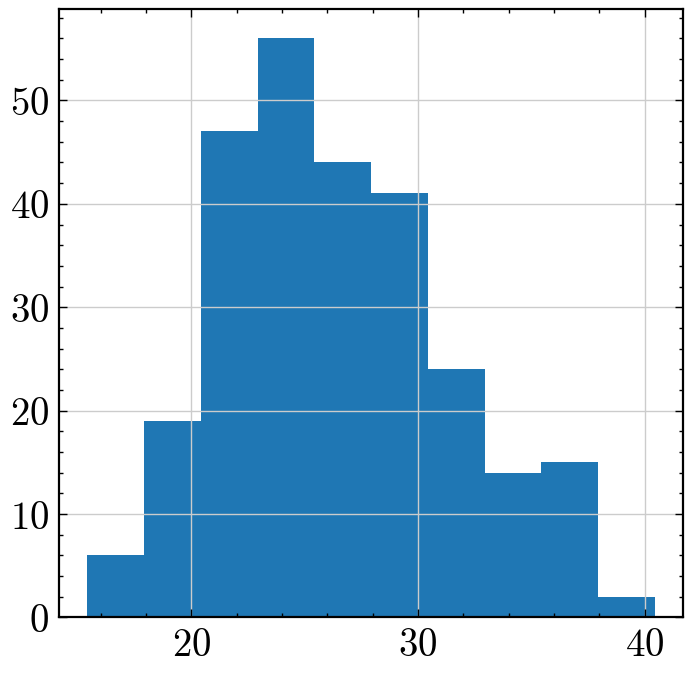

In [56]:
patienteMetadataDF['BMI'].hist()
plt.show()

## Add metadata to merged anndata object

In [57]:
mergedObj.obs = mergedObj.obs.merge(patienteMetadataDF, left_on='sampleID', right_index=True, how='left')

In [58]:
mergedObj.obs

,studyID,libraryID,sampleID,chemistry,technology,patientID,disease,timepoint_replicate,treatmentStatus,therapyResponse,sex,age,BMI,binned_age,diseaseStatus,smokingStatus,ethnicity,institute,diseaseGroup
cellID,,,,,,,,,,,,,,,,,,,
SCGT00_L051_I57.3P_T0_AAACCCAAGGTGAGAA,SCGT00,SCGT00_L051,SCGT00_I57.3P_T0,3_GEX_V3,3_GEX_V3_GenoHashed,SCGT00_I57,RA,0.0,ongoing,NR,female,47.0,25.71,41-50,na,never-smoker,na,na,IMIDs
SCGT00_L051_I56.3P_T0_AAACCCAAGTCCGTCG,SCGT00,SCGT00_L051,SCGT00_I56.3P_T0,3_GEX_V3,3_GEX_V3_GenoHashed,SCGT00_I56,RA,0.0,ongoing,R,female,56.0,30.11,51-60,na,never-smoker,na,na,IMIDs
SCGT00_L051_I53.3P_T0_AAACCCAAGTGCACTT,SCGT00,SCGT00_L051,SCGT00_I53.3P_T0,3_GEX_V3,3_GEX_V3_GenoHashed,SCGT00_I53,RA,0.0,ongoing,R,female,69.0,25.00,61-70,na,never-smoker,na,na,IMIDs
SCGT00_L051_I52.3P_T0_AAACCCACAACTGTGT,SCGT00,SCGT00_L051,SCGT00_I52.3P_T0,3_GEX_V3,3_GEX_V3_GenoHashed,SCGT00_I52,RA,0.0,ongoing,NR,female,33.0,21.37,31-40,na,never-smoker,na,na,IMIDs
SCGT00_L051_I56.3P_T0_AAACCCACAAGAATGT,SCGT00,SCGT00_L051,SCGT00_I56.3P_T0,3_GEX_V3,3_GEX_V3_GenoHashed,SCGT00_I56,RA,0.0,ongoing,R,female,56.0,30.11,51-60,na,never-smoker,na,na,IMIDs
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10XGenomics_L008_10XHC8_T0_TTTGTCATCCACGTTC,10XGenomics,10XGenomics_L008,10XGenomics_10XHC8_T0,5_GEX_V2,5_GEX_V2,10XGenomics_10XHC8,healthy,0.0,na,na,na,NaN,NaN,NaN,healthy,na,na,na,healthy
10XGenomics_L008_10XHC8_T0_TTTGTCATCCCGACTT,10XGenomics,10XGenomics_L008,10XGenomics_10XHC8_T0,5_GEX_V2,5_GEX_V2,10XGenomics_10XHC8,healthy,0.0,na,na,na,NaN,NaN,NaN,healthy,na,na,na,healthy
10XGenomics_L008_10XHC8_T0_TTTGTCATCGTGGGAA,10XGenomics,10XGenomics_L008,10XGenomics_10XHC8_T0,5_GEX_V2,5_GEX_V2,10XGenomics_10XHC8,healthy,0.0,na,na,na,NaN,NaN,NaN,healthy,na,na,na,healthy


# Split dataset for the downstream analysis

At this point, we aim to split the dataset into different pools, according intrinsic data characteristics or due to the implicit needs for the patient classifier.

* **External data**: Preselected data used to assess the performance of patient classifier on completelly independet studies (either data generated with the same 10X chemistry protocol as the one included in the inflammation atlas (**Core data**), or using a different chemistry protocol.

* **Excluded data**: Multiply observations from the same patient (e.g., multiple timepoints, replicates or same sample sequenced with different chemistry protocols).

* **Core data**: Data included in the inflammation atlas

## External data

In [59]:
# Assess datasetDF
datasetDF[['externalValidation']]

,externalValidation
0,NO
1,YES
2,NO
3,NO
4,NO
5,NO
6,NO
7,YES
8,NO
9,NO


In [60]:
# selected dataset with 'YES' and save the object
external_studiesIDs = datasetDF.studyID[datasetDF['externalValidation'] == 'YES'].tolist()
external_studiesIDs

['SCGT00val',
 'SCGT06',
 'Palshikar2022',
 'Ramachandran2019',
 'Martin2019',
 'Savage2021',
 'Jiang2020',
 'Mistry2019',
 '10XGenomics']

In [61]:
adata_external = mergedObj[mergedObj.obs.studyID.isin(external_studiesIDs)]
adata_external

View of AnnData object with n_obs × n_vars = 600032 × 37169
    obs: 'studyID', 'libraryID', 'sampleID', 'chemistry', 'technology', 'patientID', 'disease', 'timepoint_replicate', 'treatmentStatus', 'therapyResponse', 'sex', 'age', 'BMI', 'binned_age', 'diseaseStatus', 'smokingStatus', 'ethnicity', 'institute', 'diseaseGroup'
    var: 'hgnc_id', 'symbol', 'locus_group', 'HUGO_status'

In [62]:
# Save Anndata object (.h5ad file) 
adata_external.write(here("00_data_processing/results/01_INFLAMMATION_external.h5ad"), compression="gzip")

**Saving patient metadata**

In [7]:
external_sample_metadata = adata_external.obs[['studyID','sampleID','chemistry','technology','patientID','disease','timepoint_replicate','treatmentStatus',
                    'therapyResponse','sex','age','BMI','binned_age','diseaseStatus','smokingStatus','ethnicity','institute','diseaseGroup']].drop_duplicates()
assert external_sample_metadata.shape[0] == external_sample_metadata.sampleID.unique().shape[0]

In [8]:
external_sample_metadata.to_pickle(here("00_data_processing/results/01_INFLAMMATION_external_sampleMetadata.pkl"))

In [63]:
# Filter out external data from Anndata object
adata = mergedObj[~mergedObj.obs.studyID.isin(external_studiesIDs)]
adata

View of AnnData object with n_obs × n_vars = 7405391 × 37169
    obs: 'studyID', 'libraryID', 'sampleID', 'chemistry', 'technology', 'patientID', 'disease', 'timepoint_replicate', 'treatmentStatus', 'therapyResponse', 'sex', 'age', 'BMI', 'binned_age', 'diseaseStatus', 'smokingStatus', 'ethnicity', 'institute', 'diseaseGroup'
    var: 'hgnc_id', 'symbol', 'locus_group', 'HUGO_status'

## Excluded data

In [64]:
adata.obs['patientID'] = adata.obs['patientID'].astype('category')

In [65]:
excluded_samplesIDs = []

for studyID in adata.obs["studyID"].unique():
    print(studyID)

    if studyID == "SCGT00":
        # For this dataset, 32 RA samples from the same patient were processed using different chemistry (3' and 5'), but 16 additional only 3'GEX
        # Here, we aim to keep a balanced number of 3' and 5' samples (24 per chemistry). 
        # Then, we will exclude 8 samples from 5'GEX and the 24 samples from 3'GEX belonging to the patients included.
        # Since samples are the same, we also need chemistry to decide which ones to keep or remove.
        adata_obs_df = adata.obs[["patientID", "sampleID"]][(adata.obs["studyID"] == "SCGT00") & (adata.obs["chemistry"] == "5_GEX_V2")].drop_duplicates()
        df = balanced_sample(df = adata_obs_df, n = 8, random_state = 42)
        sampleID_5GEX = df["sampleID"].tolist()
        sampleID_3GEX = adata_obs_df.loc[~adata_obs_df.sampleID.isin(sampleID_5GEX), "sampleID"].tolist()
        sampleID_sub = sampleID_5GEX+sampleID_3GEX

    elif studyID == "Zhang2023":
        # For this dataset, duplicated library/sample from the same sample/patient -- REQUESTED INFORMATION
        # Here, we want to keep the sample with larger number of cells     
        cellCount = adata.obs[(adata.obs["studyID"] == "Zhang2023")].groupby(['patientID','sampleID'], observed = True).size().reset_index(name='n_cells')
        idxMax = cellCount.groupby('patientID', observed=True)['n_cells'].idxmax()
        sampleID_sub = cellCount.drop(idxMax, axis = 0)['sampleID'].tolist()

    elif studyID == "Terekhova2023":
        # For this dataset, duplicated ? from the same sample/patient
        cellCount = adata.obs[(adata.obs["studyID"] == "Terekhova2023")].groupby(['patientID','sampleID'], observed = True).size().reset_index(name='n_cells')
        idxMax = cellCount.groupby('patientID', observed=True)['n_cells'].idxmax()
        sampleID_sub = cellCount.drop(idxMax, axis = 0)['sampleID'].tolist()

    elif studyID == "Perez2022":
        # For this dataset, duplicated ? from the same sample/patient
        # Here, we will keep the T0 for the 13 longitudinal studies
        priority_order = ['Flare', 'Treated', 'Managed']
        
        adata_obs_df = adata.obs[["patientID", "sampleID", "diseaseStatus"]][adata.obs["studyID"] == "Perez2022"].drop_duplicates()
        adata_obs_df["patientID"] = adata_obs_df["patientID"].cat.remove_unused_categories()
    
        selected_samples = {}
        for patient, group in adata_obs_df.groupby('patientID'):
            # If all disease statuses are the same
            if group['diseaseStatus'].nunique() == 1:
                selected_samples[patient] = [group['sampleID'].iloc[0]]
            else:
                for status in priority_order:
                    try:
                        # Find the first sample with the highest priority status
                        selected_sample = group[group['diseaseStatus'] == status]['sampleID'].iloc[0]
                    except IndexError:
                        continue
                    # Check if this sample's status is not already selected for this patient
                    if status not in [group[group['sampleID'] == s]['diseaseStatus'].iloc[0] for s in selected_samples.get(patient, [])]:
                        selected_samples.setdefault(patient, []).append(selected_sample)
                        break
        selected_samples = list(set(value for sublist in selected_samples.values() for value in sublist))
        sampleID_sub = adata_obs_df.loc[~adata_obs_df["sampleID"].isin(selected_samples), "sampleID"].tolist()


    elif studyID == "COMBAT2022":
        # For this dataset, duplicated samples from the same patient, at different diseaseStatus and/or timePoints
        # Here, we aim to keep samples from SEVERE > MILD > CRITICAL , and T0 > T1 == T2 == Tn; thus, excluding the rest
        priority_order = ['COVID_SEV', 'COVID_MILD', 'COVID_HCW_MILD', 'COVID_CRIT', 'COVID_LDN']
                
        adata_obs_df = adata.obs[["patientID", "sampleID", "diseaseStatus"]][adata.obs["studyID"] == "COMBAT2022"].drop_duplicates()
        adata_obs_df["patientID"] = adata_obs_df["patientID"].cat.remove_unused_categories()
    
        selected_samples = {}
        for patient, group in adata_obs_df.groupby('patientID'):
            # If all disease statuses are the same
            if group['diseaseStatus'].nunique() == 1:
                selected_samples[patient] = [group['sampleID'].iloc[0]]
            else:
                for status in priority_order:
                    try:
                        # Find the first sample with the highest priority status
                        selected_sample = group[group['diseaseStatus'] == status]['sampleID'].iloc[0]
                    except IndexError:
                        continue
                    # Check if this sample's status is not already selected for this patient
                    if status not in [group[group['sampleID'] == s]['diseaseStatus'].iloc[0] for s in selected_samples.get(patient, [])]:
                        selected_samples.setdefault(patient, []).append(selected_sample)
                        break
        selected_samples = list(set(value for sublist in selected_samples.values() for value in sublist))
        sampleID_sub = adata_obs_df.loc[~adata_obs_df["sampleID"].isin(selected_samples), "sampleID"].tolist()
    
    elif studyID == "Ren2021":
        # For this dataset, duplicated samples from the same sample/patient, at different diseaseStatus / timePoints
        priority_order = ['mild/moderate_progression', 'severe/critical_progression', 'mild/moderate_convalescence', 'severe/critical_convalescence', 'healthy']

        adata_obs_df = adata.obs[["patientID", "sampleID", "diseaseStatus"]][adata.obs["studyID"] == "Ren2021"].drop_duplicates()
        adata_obs_df["patientID"] = adata_obs_df["patientID"].cat.remove_unused_categories()
    
        selected_samples = {}
        for patient, group in adata_obs_df.groupby('patientID'):
            # If all disease statuses are the same
            if group['diseaseStatus'].nunique() == 1:
                selected_samples[patient] = [group['sampleID'].iloc[0]]
            else:
                for status in priority_order:
                    try:
                        # Find the first sample with the highest priority status
                        selected_sample = group[group['diseaseStatus'] == status]['sampleID'].iloc[0]
                    except IndexError:
                        continue
                    # Check if this sample's status is not already selected for this patient
                    if status not in [group[group['sampleID'] == s]['diseaseStatus'].iloc[0] for s in selected_samples.get(patient, [])]:
                        selected_samples.setdefault(patient, []).append(selected_sample)
                        break
        selected_samples = list(set(value for sublist in selected_samples.values() for value in sublist))
        sampleID_sub = adata_obs_df.loc[~adata_obs_df["sampleID"].isin(selected_samples), "sampleID"].tolist()
    
    else:
        continue

    excluded_samplesIDs += sampleID_sub

SCGT00
SCGT01
SCGT02
SCGT03
SCGT04
SCGT05
Reyes2020
Cillo2020
Zhang2023
Schafflick2020
Liu2021
Terekhova2023
Perez2022
Wang2020
COMBAT2022
Ren2021


Ren2021


In [66]:
len(excluded_samplesIDs)

228

In [67]:
adata_excluded = adata[adata.obs.sampleID.isin(excluded_samplesIDs)]
adata_excluded

View of AnnData object with n_obs × n_vars = 1388686 × 37169
    obs: 'studyID', 'libraryID', 'sampleID', 'chemistry', 'technology', 'patientID', 'disease', 'timepoint_replicate', 'treatmentStatus', 'therapyResponse', 'sex', 'age', 'BMI', 'binned_age', 'diseaseStatus', 'smokingStatus', 'ethnicity', 'institute', 'diseaseGroup'
    var: 'hgnc_id', 'symbol', 'locus_group', 'HUGO_status'

In [68]:
# Save Anndata object (.h5ad file) 
adata_excluded.write(here("00_data_processing/results/01_INFLAMMATION_excluded.h5ad"), compression="gzip")

In [12]:
adata_excluded = sc.read_h5ad(here("00_data_processing/results/01_INFLAMMATION_excluded.h5ad"), backed='r')

**Saving patient metadata**

In [13]:
excluded_sample_metadata = adata_excluded.obs[['studyID','sampleID','chemistry','technology','patientID','disease','timepoint_replicate','treatmentStatus',
                    'therapyResponse','sex','age','BMI','binned_age','diseaseStatus','smokingStatus','ethnicity','institute','diseaseGroup']].drop_duplicates()
assert excluded_sample_metadata.shape[0] == excluded_sample_metadata.sampleID.unique().shape[0]

In [14]:
excluded_sample_metadata.to_pickle(here("00_data_processing/results/01_INFLAMMATION_excluded_sampleMetadata.pkl"))

In [69]:
grouped = adata_excluded.obs.groupby(["studyID", "chemistry", "disease", "sex", "binned_age"])
results = grouped["patientID"].nunique().reset_index().rename(columns={"patientID": "patient_count"})
results = results[results["patient_count"] > 0].reset_index()
results

,index,studyID,chemistry,disease,sex,binned_age,patient_count
0,169,COMBAT2022,5_GEX_V1,COVID,female,31-40,2
1,171,COMBAT2022,5_GEX_V1,COVID,female,51-60,2
2,172,COMBAT2022,5_GEX_V1,COVID,female,61-70,1
3,173,COMBAT2022,5_GEX_V1,COVID,female,71-80,2
4,175,COMBAT2022,5_GEX_V1,COVID,male,18-30,1
5,176,COMBAT2022,5_GEX_V1,COVID,male,31-40,1
6,180,COMBAT2022,5_GEX_V1,COVID,male,71-80,2
7,240,COMBAT2022,5_GEX_V1,sepsis,female,41-50,1
8,250,COMBAT2022,5_GEX_V1,sepsis,male,71-80,1
9,378,Perez2022,3_GEX_V2,SLE,female,18-30,8


## Core data

In [70]:
# Filter out external data from Anndata object
adata_core = adata[~adata.obs.sampleID.isin(excluded_samplesIDs)]
adata_core

View of AnnData object with n_obs × n_vars = 6016705 × 37169
    obs: 'studyID', 'libraryID', 'sampleID', 'chemistry', 'technology', 'patientID', 'disease', 'timepoint_replicate', 'treatmentStatus', 'therapyResponse', 'sex', 'age', 'BMI', 'binned_age', 'diseaseStatus', 'smokingStatus', 'ethnicity', 'institute', 'diseaseGroup'
    var: 'hgnc_id', 'symbol', 'locus_group', 'HUGO_status'

In [71]:
adata_core.obs.patientID.unique()

['SCGT00_I57', 'SCGT00_I56', 'SCGT00_I53', 'SCGT00_I52', 'SCGT00_I51', ..., 'Ren2021_PS049', 'Ren2021_PS050', 'Ren2021_PS051', 'Ren2021_PS052', 'Ren2021_PS053']
Length: 994
Categories (994, object): ['COMBAT2022_G05061', 'COMBAT2022_G05064', 'COMBAT2022_G05073', 'COMBAT2022_G05077', ..., 'Zhang2023_P191126', 'Zhang2023_P191127', 'Zhang2023_P191210', 'Zhang2023_P191217']

In [72]:
# Ensure data has unique PATIENT samples.
assert len(adata_core.obs.patientID.unique()) == len(adata_core.obs.sampleID.unique())

In [ ]:
# Save Anndata object (.h5ad file) 
adata_core.write(here("00_data_processing/results/01_INFLAMMATION_core.h5ad"), compression="gzip")

In [74]:
# Session info
session_info.show()

In [ ]:
doctis = pd.read_pickle(here("00_data_processing/results/extended_obs/SCGT00_obs.pkl"))

In [ ]:
doctis.head()